<a href="https://colab.research.google.com/github/LoukiaPavlana/Advanced-Databases/blob/main/MCP_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install holidays

In [ ]:
import pandas as pd
from IPython.display import display
import warnings
import matplotlib.pyplot as plt
import glob
import openpyxl

##Market clearing price for September 2024

* Created a Date and hour collumn, and sorted the data according to their values
* Created a collumn corresponding to the day of the week with 1:Sunday , 2:Monday etc.
* Used the holiday library to create a collumn for whether its a holiday or a working day with 1 corresponding to a holiday and 0 to a working date

In [ ]:
import os
import numpy as np
import holidays  # Import the holidays library to find Greek Holidays

# Define Greek holidays
gr_holidays = holidays.Greece()

# Define folder path where all Excel files are located
folder_path = '/content/drive/MyDrive/Day-Ahead-Market-Data/Results summary sept 2024'

# Initialize a list to store each file's hourly data
all_data = []
rows_with_na_accumulated = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df_market_price_hourly = {}

        try:
            # Load the workbook and sheet
            workbook = openpyxl.load_workbook(file_path)
            sheet = workbook['MKT_Coupling']

            # Unfreeze panes and clear filters if any exist
            sheet.freeze_panes = None
            if sheet.auto_filter.ref:
                sheet.auto_filter.ref = None

            # Save any changes
            workbook.save(file_path)

            # Load the DataFrame, skipping the first row and using the second row as header
            df = pd.read_excel(file_path, sheet_name='MKT_Coupling', header=1)
            df.dropna(axis=1, how='all', inplace=True)
            df_cleaned = df[~df.iloc[:, 0].str.contains("Day-Ahead Market Coupling Results", na=False)]
            df_cleaned.dropna(how='all', inplace=True)
            df_cleaned.reset_index(drop=True, inplace=True)

            # Get the date value from the specified cell
            Date = sheet.cell(row=2, column=1).value  # Extract date from cell (e.g., B2) (where the date is located in the file)

            # Drop the 25th column if it exists
            if df_cleaned.shape[1] >= 26:
                df_cleaned.drop(df_cleaned.columns[25], axis=1, inplace=True)


            # Convert columns to numeric where possible without replacing 0.00 or 0.01
            for col in df_cleaned.columns[1:]:
                # Ensure that only non-numeric values (like strings) are converted to NaN
                df_cleaned[col] = pd.to_numeric(df_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

            # Find and accumulate rows with NaN or pd.NA values
            rows_with_na = df_Hourly[df_Hourly.isna().any(axis=1)]
            rows_with_na_accumulated = pd.concat([rows_with_na_accumulated, rows_with_na])

            # Replace NaN or pd.NA values with 0, keeping small decimals intact
            df_Hourly = df_Hourly.map(lambda x: 0 if pd.isna(x) else x)

            # Define starting row indices for sections
            start_market_price = df_cleaned[df_cleaned.iloc[:, 0] == 'Market Clearing Price'].index[0]
            start_imports_implicit = df_cleaned[df_cleaned.iloc[:, 0] == 'BORDER IMPORTS (IMPLICIT)'].index[0]

            # Extract the 'Market Clearing Price' section
            df_market_price = df_cleaned.iloc[start_market_price:start_imports_implicit].dropna(how='all')
            df_market_price.set_index(df_market_price.columns[0], inplace=True)

            # Collect hourly data only if there are enough columns
            for Hour in range(1, min(25, df_market_price.shape[1] + 1)):  # Ensure we don't exceed available columns
                Hourly_data = df_market_price.iloc[:, Hour - 1]  # Get data for the Hour
                df_market_price_hourly[(Date, Hour)] = Hourly_data

            # Convert hourly data dictionary to a DataFrame
            df_Hourly = pd.DataFrame(df_market_price_hourly).T
            df_Hourly.index.names = ['Date', 'Hour']
            df_Hourly.reset_index(inplace=True)

            # Add "Day of the Week" column as an integer (1 for Sunday, 2 for Monday, etc.)
            df_Hourly['Day of the Week'] = df_Hourly['Date'].apply(lambda x: (x.weekday() + 2) % 7 + 1)

            # Add "Is Holiday" column based on Greek public holidays
            df_Hourly['Is Holiday'] = df_Hourly['Date'].apply(lambda x: 1 if x in gr_holidays else 0)

            # Reorder the columns to make "Day of the Week" the second column
            df_Hourly = df_Hourly[['Date', 'Day of the Week', 'Hour', 'Is Holiday'] +
                                  [col for col in df_Hourly.columns if col not in ['Date', 'Day of the Week', 'Hour', 'Is Holiday']]]

            # Replace any missing or invalid values and sort
            df_Hourly.replace(['', 'NaN', 'nan'], pd.NA, inplace=True)
            df_Hourly.fillna(0, inplace=True)

            # Append to the all_data list
            all_data.append(df_Hourly)

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Concatenate all DataFrames into a single DataFrame and sort by Date and Hour
if all_data:  # Check if there is any data to concatenate
    combined_df_Sept2024 = pd.concat(all_data, ignore_index=True)
    combined_df_Sept2024.sort_values(by=['Date', 'Hour'], inplace=True) #Sort data by Date and Hour
    combined_df_Sept2024.reset_index(drop=True, inplace=True)
    if combined_df_Sept2024.shape[1] >= 2:  # Ensure there are at least two columns
        combined_df_Sept2024.drop(combined_df_Sept2024.columns[-2], axis=1, inplace=True)

    # Rename the last column to 'Market Clearing Price'
    combined_df_Sept2024.rename(columns={combined_df_Sept2024.columns[-1]: 'Market Clearing Price'}, inplace=True)

    # Display the final combined DataFrame
    print("\nCombined Market Clearing Price Data:")
    display(combined_df_Sept2024)
else:
    print("No valid data to display.")

display(rows_with_na_accumulated)

In [ ]:
combined_df_Sept2024.to_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_Sept_2024.csv')

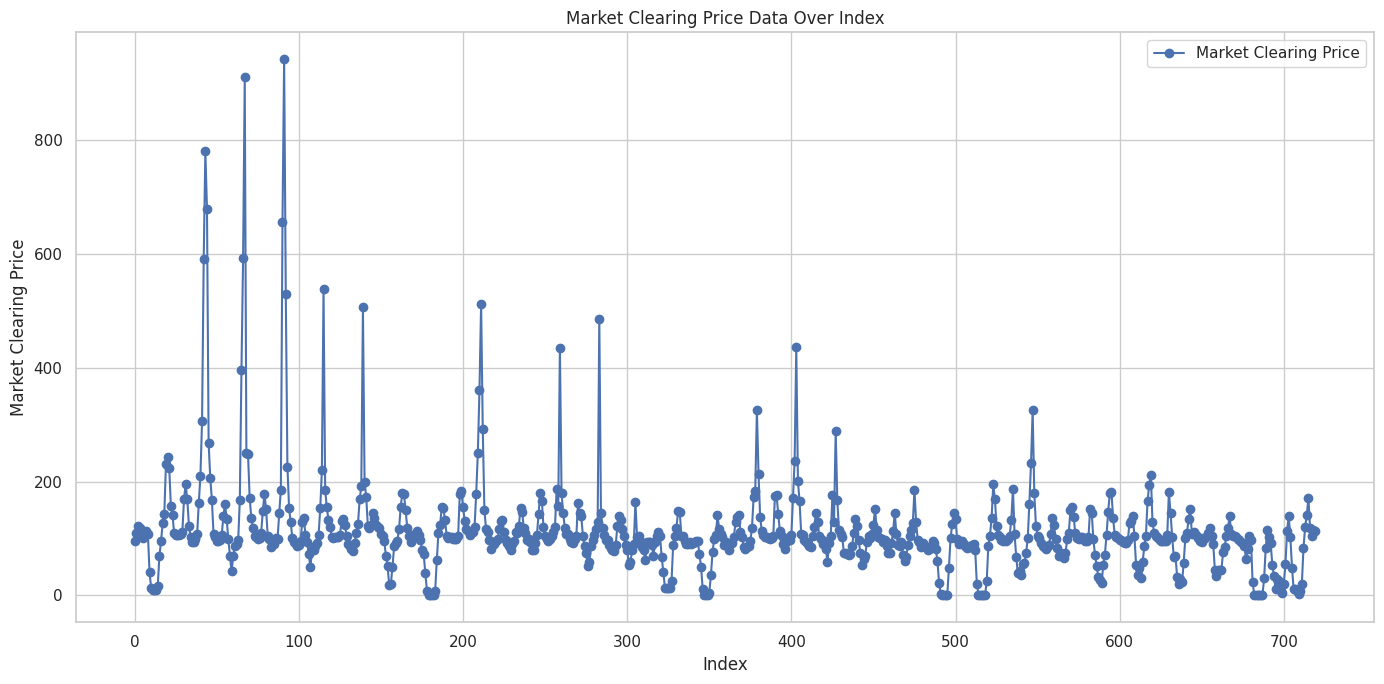

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(combined_df_Sept2024.index, combined_df_Sept2024['Market Clearing Price'], marker='o', linestyle='-', color='b',  label='Market Clearing Price')

# Adding titles and labels
plt.title('Market Clearing Price Data Over Index')
plt.xlabel('Index')
plt.ylabel('Market Clearing Price')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

Plotting the average MCP across the working days of the week to identify any recurring patterns based on the time of day.

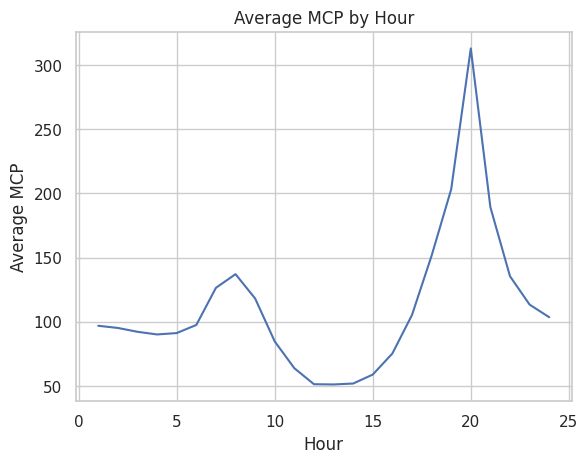

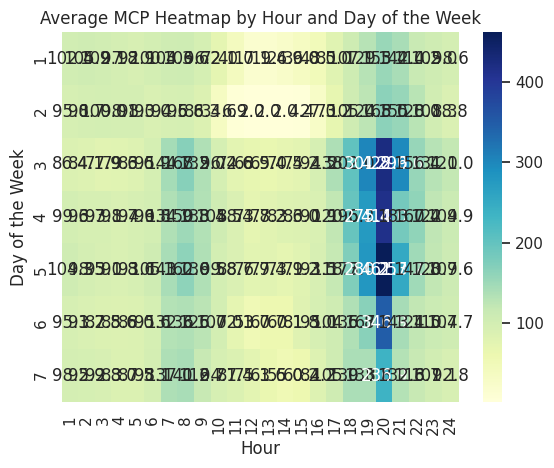

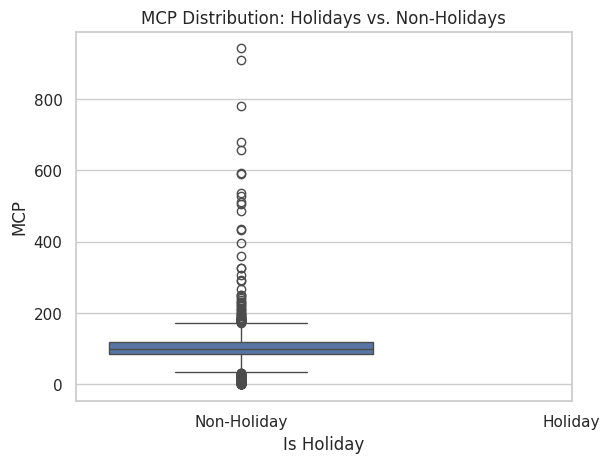

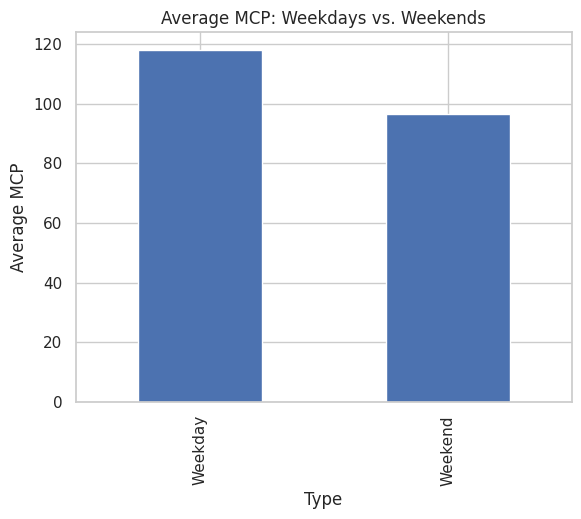

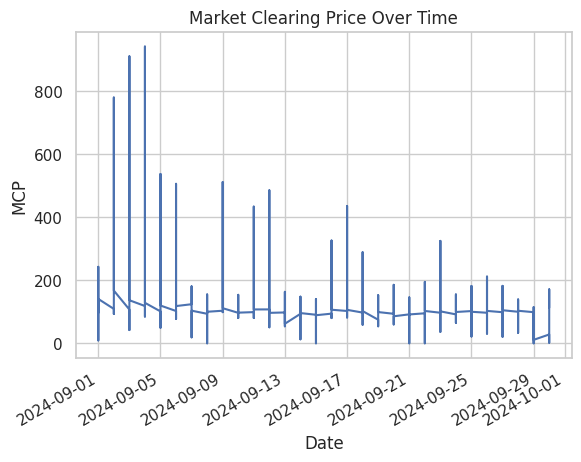

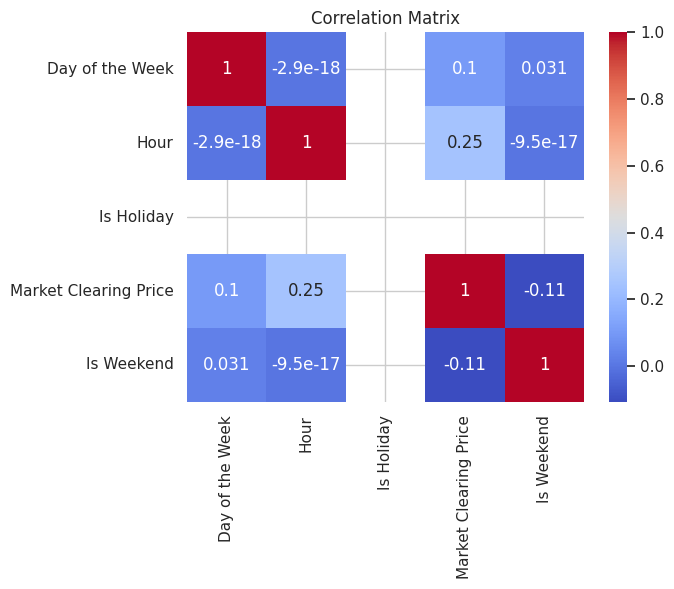

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Create a copy of combined_df
df = combined_df_Sept2024.copy()

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# 1. Plot: Average MCP by Hour
hourly_avg = df.groupby('Hour')['Market Clearing Price'].mean()
hourly_avg.plot(kind='line', title='Average MCP by Hour', xlabel='Hour', ylabel='Average MCP')
plt.show()  # Display plot immediately

# 2. Heatmap for average MCP by Hour and Day of the Week
heatmap_data = df.pivot_table(values='Market Clearing Price', index='Day of the Week', columns='Hour', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average MCP Heatmap by Hour and Day of the Week')
plt.xlabel('Hour')
plt.ylabel('Day of the Week')
plt.show()  # Display heatmap

# 3. Boxplot for Holidays vs. Non-Holidays
sns.boxplot(x='Is Holiday', y='Market Clearing Price', data=df)
plt.title('MCP Distribution: Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('MCP')
plt.show()  # Display boxplot

# 4. Bar Plot: Weekdays vs. Weekends
df['Is Weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in [7, 1] else 0)  # Sunday=1, Saturday=7
weekend_avg = df.groupby('Is Weekend')['Market Clearing Price'].mean()
weekend_avg.plot(kind='bar', title='Average MCP: Weekdays vs. Weekends', ylabel='Average MCP', xlabel='Type')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()  # Display bar plot

# 5. Line Plot: Market Clearing Price Over Time
df.set_index('Date', inplace=True)  # Set 'Date' as index for time series
df['Market Clearing Price'].plot(title='Market Clearing Price Over Time', xlabel='Date', ylabel='MCP')
plt.show()  # Display time series plot

# 6. Heatmap of Correlation Matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()  # Display correlation heatmap


**Box plot explanation:**

**Box:** The main part of the plot (a rectangle) represents the interquartile range (IQR) of the data, which is the range between the first quartile (Q1) and third quartile (Q3).

* First quartile (Q1): The median of the lower half of the data.
* Third quartile (Q3): The median of the upper half of the data.
Median line: A line within the box represents the median (Q2) of the data, showing the middle value of the dataset.

**Whiskers:** Lines (or "whiskers") extending from either side of the box indicate the range of the data within a specified limit, often 1.5 times the IQR from Q1 and Q3.

* The whiskers may reach to the minimum and maximum data points within this range, excluding outliers.

**Outliers:** Data points that fall outside the whiskers' range (often beyond 1.5 times the IQR from Q1 or Q3) are marked separately as individual points or symbols.

##Market Clearing price for 2024 (up to Octomber)


In [ ]:
import os
import numpy as np
import holidays  # Import the holidays library to find Greek Holidays

# Define Greek holidays
gr_holidays = holidays.Greece()

# Define folder path where all Excel files are located
folder_path = '/content/drive/MyDrive/Day-Ahead-Market-Data/ResultsSummary2024'

# Initialize a list to store each file's hourly data
all_data = []
rows_with_na_accumulated = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df_market_price_hourly = {}

        try:
            # Load the workbook and sheet
            workbook = openpyxl.load_workbook(file_path)
            sheet = workbook['MKT_Coupling']

            # Unfreeze panes and clear filters if any exist
            sheet.freeze_panes = None
            if sheet.auto_filter.ref:
                sheet.auto_filter.ref = None

            # Save any changes
            workbook.save(file_path)

            # Load the DataFrame, skipping the first row and using the second row as header
            df = pd.read_excel(file_path, sheet_name='MKT_Coupling', header=1)
            df.dropna(axis=1, how='all', inplace=True)
            df_cleaned = df[~df.iloc[:, 0].str.contains("Day-Ahead Market Coupling Results", na=False)]
            df_cleaned.dropna(how='all', inplace=True)
            df_cleaned.reset_index(drop=True, inplace=True)

            # Get the date value from the specified cell
            Date = sheet.cell(row=2, column=1).value  # Extract date from cell (e.g., B2) (where the date is located in the file)

            # Drop the 25th column if it exists
            if df_cleaned.shape[1] >= 26:
                df_cleaned.drop(df_cleaned.columns[25], axis=1, inplace=True)


            # Convert columns to numeric where possible without replacing 0.00 or 0.01
            for col in df_cleaned.columns[1:]:
                # Ensure that only non-numeric values (like strings) are converted to NaN
                df_cleaned[col] = pd.to_numeric(df_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

            # Find and accumulate rows with NaN or pd.NA values
            rows_with_na = df_Hourly[df_Hourly.isna().any(axis=1)]
            rows_with_na_accumulated = pd.concat([rows_with_na_accumulated, rows_with_na])

            # Replace NaN or pd.NA values with 0, keeping small decimals intact
            df_Hourly = df_Hourly.map(lambda x: 0 if pd.isna(x) else x)

            # Define starting row indices for sections
            start_market_price = df_cleaned[df_cleaned.iloc[:, 0] == 'Market Clearing Price'].index[0]
            start_imports_implicit = df_cleaned[df_cleaned.iloc[:, 0] == 'BORDER IMPORTS (IMPLICIT)'].index[0]

            # Extract the 'Market Clearing Price' section
            df_market_price = df_cleaned.iloc[start_market_price:start_imports_implicit].dropna(how='all')
            df_market_price.set_index(df_market_price.columns[0], inplace=True)

            # Collect hourly data only if there are enough columns
            for Hour in range(1, min(25, df_market_price.shape[1] + 1)):  # Ensure we don't exceed available columns
                Hourly_data = df_market_price.iloc[:, Hour - 1]  # Get data for the Hour
                df_market_price_hourly[(Date, Hour)] = Hourly_data

            # Convert hourly data dictionary to a DataFrame
            df_Hourly = pd.DataFrame(df_market_price_hourly).T
            df_Hourly.index.names = ['Date', 'Hour']
            df_Hourly.reset_index(inplace=True)

            # Add "Day of the Week" column as an integer (1 for Sunday, 2 for Monday, etc.)
            df_Hourly['Day of the Week'] = df_Hourly['Date'].apply(lambda x: (x.weekday() + 2) % 7 + 1)

            # Add "Is Holiday" column based on Greek public holidays
            df_Hourly['Is Holiday'] = df_Hourly['Date'].apply(lambda x: 1 if x in gr_holidays else 0)

            # Reorder the columns to make "Day of the Week" the second column
            df_Hourly = df_Hourly[['Date', 'Day of the Week', 'Hour', 'Is Holiday'] +
                                  [col for col in df_Hourly.columns if col not in ['Date', 'Day of the Week', 'Hour', 'Is Holiday']]]

            # Replace any missing or invalid values and sort
            df_Hourly.replace(['', 'NaN', 'nan'], pd.NA, inplace=True)
            df_Hourly.fillna(0, inplace=True)

            # Append to the all_data list
            all_data.append(df_Hourly)

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Concatenate all DataFrames into a single DataFrame and sort by Date and Hour
if all_data:  # Check if there is any data to concatenate
    combined_df_2024 = pd.concat(all_data, ignore_index=True)
    combined_df_2024.sort_values(by=['Date', 'Hour'], inplace=True) #Sort data by Date and Hour
    combined_df_2024.reset_index(drop=True, inplace=True)
    if combined_df_2024.shape[1] >= 2:  # Ensure there are at least two columns
        combined_df_2024.drop(combined_df_2024.columns[-2], axis=1, inplace=True)

    # Rename the last column to 'Market Clearing Price'
    combined_df_2024.rename(columns={combined_df_2024.columns[-1]: 'Market Clearing Price'}, inplace=True)

    # Display the final combined DataFrame
    print("\nCombined Market Clearing Price Data:")
    display(combined_df_2024)
else:
    print("No valid data to display.")

display(rows_with_na_accumulated)

Error processing file 20240103_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240108_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240104_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240102_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240105_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240110_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240114_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240111_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240107_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing file 20240113_EL-DAM_ResultsSummary_EN_v01.xlsx: name 'df_Hourly' is not defined
Error processing fil

KeyboardInterrupt: 

Clearing prices that are zero:

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2024.csv')

# Filter rows where Market Clearing Price is less than 1
near_zero_values = df[df['Market Clearing Price'] < 1]

# Print the rows
display(near_zero_values)

# Count the rows
near_zero_count = near_zero_values.shape[0]
print(f"Total rows with Market Clearing Price less than 1: {near_zero_count}")

Unnamed: 0        Date  Day of the Week  Hour  Is Holiday  \
11            11  2024-01-01                3    12           1   
1906        1906  2024-03-20                5    11           0   
1978        1978  2024-03-23                1    11           0   
1979        1979  2024-03-23                1    12           0   
2000        2000  2024-03-24                2     9           0   
...          ...         ...              ...   ...         ...   
7138        7138  2024-10-24                6    12           0   
7139        7139  2024-10-24                6    13           0   
7304        7304  2024-10-31                6    10           0   
7305        7305  2024-10-31                6    11           0   
7306        7306  2024-10-31                6    12           0   

      Market Clearing Price  
11                     0.54  
1906                   0.20  
1978                   0.20  
1979                   0.20  
2000                   0.01  
...                     ...  
7138                   0.04  
7139                   0.04  
7304                   0.04  
7305                   0.04  
7306                   0.04  

[211 rows x 6 columns]

Total rows with Market Clearing Price less than 1: 211


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2023.csv')

# Filter rows where Market Clearing Price is less than 1
near_zero_values = df[df['Market Clearing Price'] < 1]

# Print the rows
display(near_zero_values)

# Count the rows
near_zero_count = near_zero_values.shape[0]
print(f"Total rows with Market Clearing Price less than 1: {near_zero_count}")

Unnamed: 0        Date  Day of the Week  Hour  Is Holiday  \
410          410  2023-01-18                5     3           0   
411          411  2023-01-18                5     4           0   
434          434  2023-01-19                6     3           0   
435          435  2023-01-19                6     4           0   
436          436  2023-01-19                6     5           0   
...          ...         ...              ...   ...         ...   
7737        7737  2023-11-19                2    11           0   
7738        7738  2023-11-19                2    12           0   
7739        7739  2023-11-19                2    13           0   
7740        7740  2023-11-19                2    14           0   
8604        8604  2023-12-25                3    14           1   

      Market Clearing Price  
410                    0.56  
411                    0.56  
434                    0.49  
435                    0.49  
436                    0.49  
...                     ...  
7737                   0.00  
7738                   0.01  
7739                   0.01  
7740                   0.99  
8604                   0.04  

[71 rows x 6 columns]

Total rows with Market Clearing Price less than 1: 71


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2023_2024.csv')

# Filter rows where Market Clearing Price is less than 1
near_zero_values = df[df['Market Clearing Price'] < 1]

# Print the rows
display(near_zero_values)

# Count the rows
near_zero_count = near_zero_values.shape[0]
print(f"Total rows with Market Clearing Price less than 1: {near_zero_count}")

Unnamed: 0.1  Unnamed: 0        Date  Day of the Week  Hour  \
410             410         410  2023-01-18                5     3   
411             411         411  2023-01-18                5     4   
434             434         434  2023-01-19                6     3   
435             435         435  2023-01-19                6     4   
436             436         436  2023-01-19                6     5   
...             ...         ...         ...              ...   ...   
15897         15897        7138  2024-10-24                6    12   
15898         15898        7139  2024-10-24                6    13   
16063         16063        7304  2024-10-31                6    10   
16064         16064        7305  2024-10-31                6    11   
16065         16065        7306  2024-10-31                6    12   

       Is Holiday  Market Clearing Price  
410             0                   0.56  
411             0                   0.56  
434             0                   0.49  
435             0                   0.49  
436             0                   0.49  
...           ...                    ...  
15897           0                   0.04  
15898           0                   0.04  
16063           0                   0.04  
16064           0                   0.04  
16065           0                   0.04  

[282 rows x 7 columns]

Total rows with Market Clearing Price less than 1: 282


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2023_2024.csv')

# Filter rows where Market Clearing Price is less than 1
near_zero_values = df[df['Market Clearing Price'] < 1]

# Create a lag-24 column for Market Clearing Price
df['Market Clearing Price Lag 24'] = df['Market Clearing Price'].shift(24)

# Replace values less than 1 with the lag-24 value
df.loc[df['Market Clearing Price'] < 1, 'Market Clearing Price'] = df.loc[df['Market Clearing Price'] < 1, 'Market Clearing Price Lag 24']

# Drop the temporary lag column if no longer needed
df.drop(columns=['Market Clearing Price Lag 24'], inplace=True)

# Save the updated DataFrame or display as needed
print(f"Total rows with updated values: {near_zero_count}")
display(df[df['Market Clearing Price'] < 1])  # Confirm there are no values less than 1 now


Total rows with updated values: 282


Unnamed: 0.1  Unnamed: 0        Date  Day of the Week  Hour  \
434             434         434  2023-01-19                6     3   
435             435         435  2023-01-19                6     4   
458             458         458  2023-01-20                7     3   
459             459         459  2023-01-20                7     4   
460             460         460  2023-01-20                7     5   
...             ...         ...         ...              ...   ...   
12276         12276        3517  2024-05-26                2    15   
12277         12277        3518  2024-05-26                2    16   
15130         15130        6371  2024-09-22                2    13   
15131         15131        6372  2024-09-22                2    14   
15132         15132        6373  2024-09-22                2    15   

       Is Holiday  Market Clearing Price  
434             0                   0.56  
435             0                   0.56  
458             0                   0.49  
459             0                   0.49  
460             0                   0.49  
...           ...                    ...  
12276           0                   0.04  
12277           0                   0.05  
15130           0                   0.04  
15131           0                   0.04  
15132           0                   0.04  

[73 rows x 7 columns]

In [ ]:
df= combined_df_2024.copy()
zero_values = df[df['Market Clearing Price'] == 0]
print(zero_values)
zero_count = (df['Market Clearing Price'] == 0).sum()
print(f"Total rows with zero Market Clearing Price: {zero_count}")

           Date  Day of the Week  Hour  Is Holiday  Market Clearing Price
2003 2024-03-24                2    12           0                    0.0
2004 2024-03-24                2    13           0                    0.0
2005 2024-03-24                2    14           0                    0.0
2006 2024-03-24                2    15           0                    0.0
2172 2024-03-31                2    13           0                    0.0
2173 2024-03-31                2    14           0                    0.0
2197 2024-04-01                3    15           0                    0.0
2338 2024-04-07                2    12           0                    0.0
2339 2024-04-07                2    13           0                    0.0
2340 2024-04-07                2    14           0                    0.0
2342 2024-04-07                2    16           0                    0.0
2482 2024-04-13                1    12           0                    0.0
2483 2024-04-13                1    13

In [ ]:
# Set 'Date' as the index if it's not already, and ensure it is a DateTimeIndex
df= combined_df_2024.copy()
# Combine Date and Hour into a single DateTime column if they are separate
df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
df = df.set_index('DateTime').sort_index()

# Now reindex to find missing hourly entries
expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # Use lowercase 'h' for hours
df_reindexed = df.reindex(expected_dates)
missing_rows = df_reindexed[df_reindexed.isnull().any(axis=1)]
print("Missing dates and times:")
print(missing_rows)

Missing dates and times:
           Date  Day of the Week  Hour  Is Holiday  Market Clearing Price
2024-04-01  NaT              NaN   NaN         NaN                    NaN


In [ ]:
combined_df_2024.to_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2024.csv')

In [ ]:
folder_path = '/content/drive/MyDrive/ResultsSummary2024'

### Plot the Daily Mean Market Clearing Price for date ranges

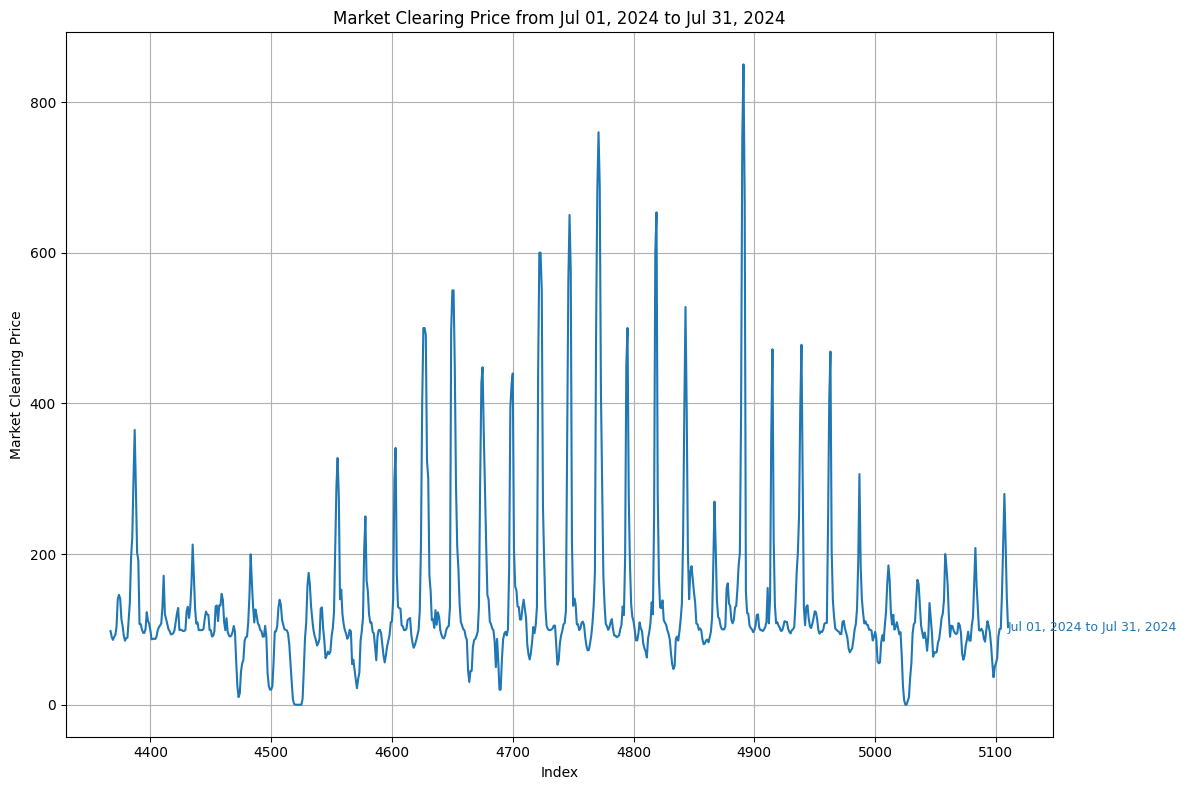

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the date range (start and end) - you can input these dates
start_date = '2024-07-01'  # Example start date
end_date = '2024-07-31'    # Example end date

# Convert the dates to datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Ensure 'Date' is a datetime object
df = combined_df_2024.copy()
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the specific date range
filtered_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Check if filtered_data is non-empty
if not filtered_data.empty:
    # Create a figure for plotting
    plt.figure(figsize=(12, 8))

    # Use the index as the x-axis and plot the Market Clearing Price
    plt.plot(filtered_data.index, filtered_data['Market Clearing Price'], label=f'{start_date.strftime("%b %d, %Y")} to {end_date.strftime("%b %d, %Y")}')

    # Add a label at the end of the line
    plt.text(filtered_data.index[-1], filtered_data['Market Clearing Price'].iloc[-1], f'{start_date.strftime("%b %d, %Y")} to {end_date.strftime("%b %d, %Y")}',
             verticalalignment='center', horizontalalignment='left', fontsize=9, color=plt.gca().lines[-1].get_color())

    # Add title and labels
    plt.title(f"Market Clearing Price from {start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}")
    plt.xlabel("Index")
    plt.ylabel("Market Clearing Price")
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the date range: {start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}.")


###Plot the Daily Mean Market Clearing Price of each month to see the comparison

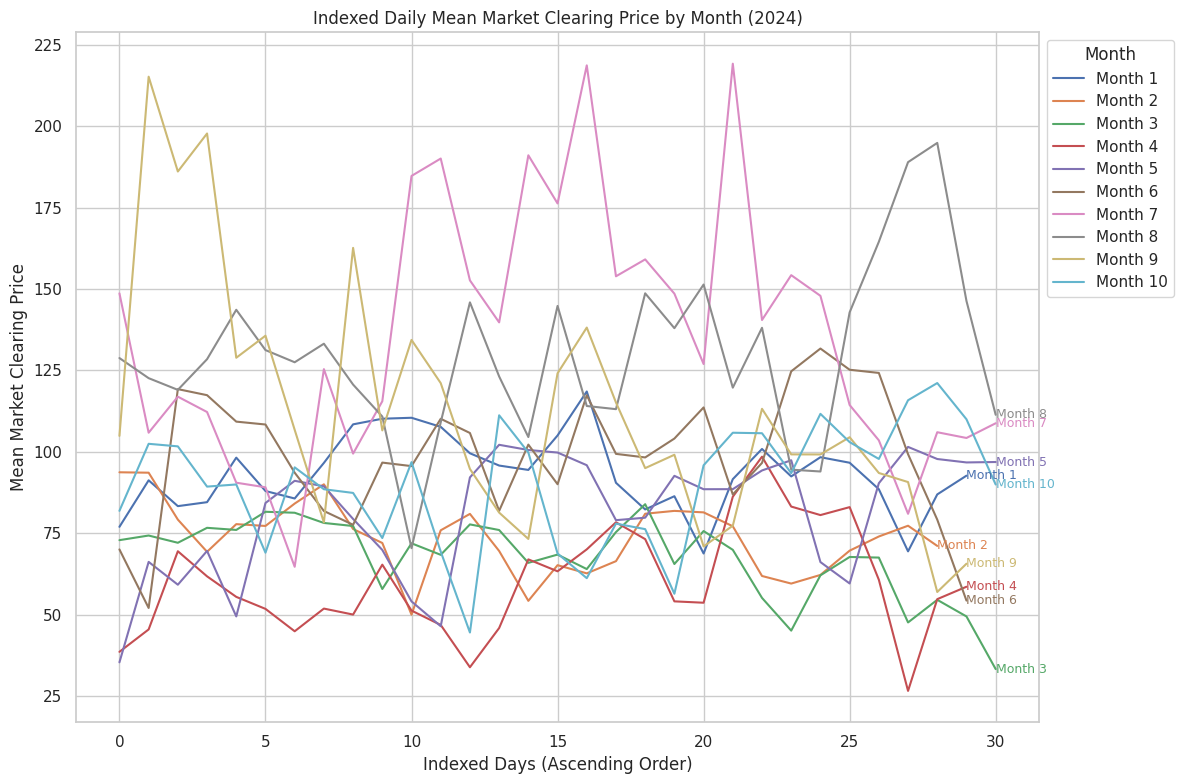

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df=combined_df_2024.copy()
# Ensure 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Loop through each month, calculate the daily mean, and plot by indexed days
for month in range(1, 13):
    # Filter data for the specific month
    monthly_data = df[df['Date'].dt.month == month]

    # Check if monthly_data is non-empty
    if not monthly_data.empty:
        # Calculate the daily mean Market Clearing Price for each date
        daily_mean = monthly_data.groupby('Date')['Market Clearing Price'].mean()

        # Reset the index to create a sequential index for plotting
        daily_mean = daily_mean.reset_index(drop=True)

        # Plot the daily mean for each month using the new sequential index
        plt.plot(daily_mean.index, daily_mean.values, label=f'Month {month}')

        # Add a label at the end of each line
        plt.text(daily_mean.index[-1], daily_mean.values[-1], f'Month {month}',
                 verticalalignment='center', horizontalalignment='left', fontsize=9, color=plt.gca().lines[-1].get_color())

# Add a legend box for month labels
plt.legend(title="Month", loc="upper left", bbox_to_anchor=(1, 1))

# Add title and labels
plt.title("Indexed Daily Mean Market Clearing Price by Month (2024)")
plt.xlabel("Indexed Days (Ascending Order)")
plt.ylabel("Mean Market Clearing Price")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


### Daily Mean Market Clearing Price by Month (2024) - Working Days only (non holiday)



<ipython-input-36-ff0004346f88>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df = df[~df['Date'].isin(gr_holidays)]  # Remove holidays


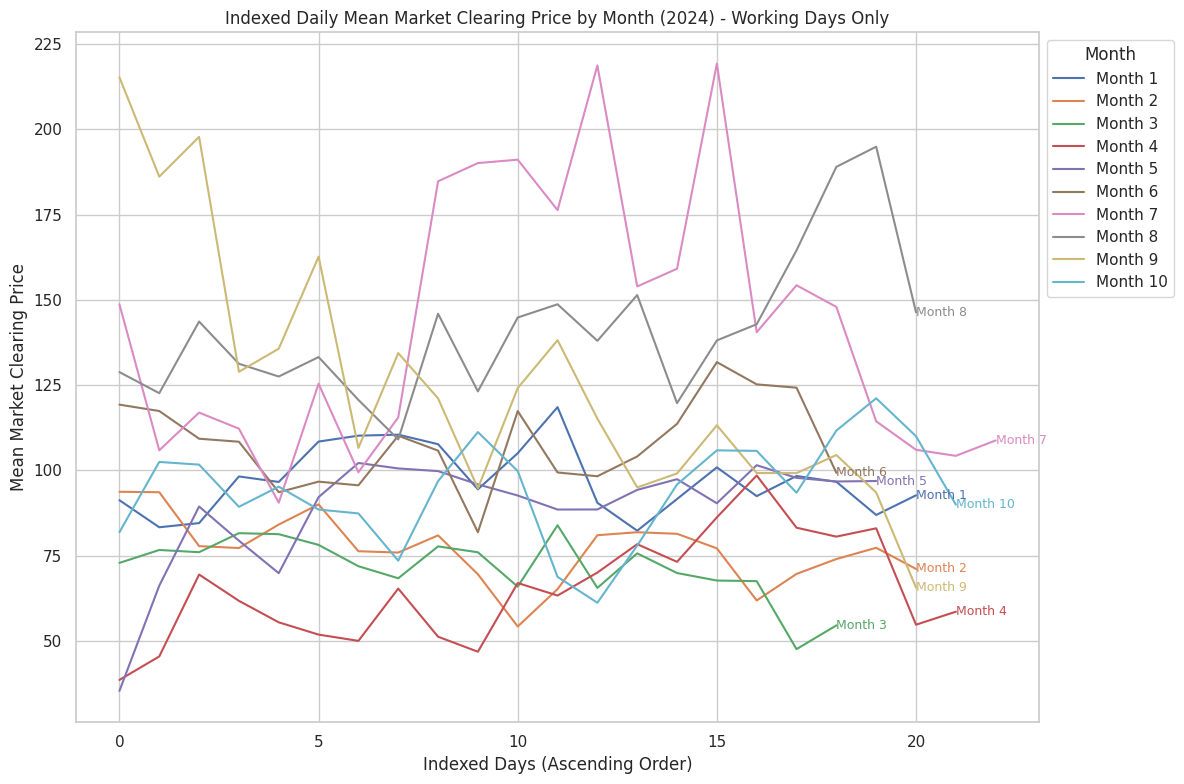

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import holidays  # Ensure this is imported to access Greek holidays

df=combined_df_2024.copy()
# Define Greek holidays for 2024
gr_holidays = holidays.Greece(years=2024)

# Ensure 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# # Filter out weekends and holidays
df['Day of Week'] = df['Date'].dt.weekday  # 0=Monday, ..., 6=Sunday
df = df[~df['Date'].isin(gr_holidays)]  # Remove holidays
df = df[df['Day of Week'] < 5]  # Keep only weekdays (Monday to Friday)

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Loop through each month, calculate the daily mean, and plot by indexed days
for month in range(1, 13):
    # Filter data for the specific month
    monthly_data = df[df['Date'].dt.month == month]

    # Check if monthly_data is non-empty
    if not monthly_data.empty:
        # Calculate the daily mean Market Clearing Price for each date
        daily_mean = monthly_data.groupby('Date')['Market Clearing Price'].mean()

        # Reset the index to create a sequential index for plotting
        daily_mean = daily_mean.reset_index(drop=True)

        # Plot the daily mean for each month using the new sequential index
        plt.plot(daily_mean.index, daily_mean.values, label=f'Month {month}')

        # Add a label at the end of each line
        plt.text(daily_mean.index[-1], daily_mean.values[-1], f'Month {month}',
                 verticalalignment='center', horizontalalignment='left', fontsize=9, color=plt.gca().lines[-1].get_color())

# Add a legend box for month labels
plt.legend(title="Month", loc="upper left", bbox_to_anchor=(1, 1))

# Add title and labels
plt.title("Indexed Daily Mean Market Clearing Price by Month (2024) - Working Days Only")
plt.xlabel("Indexed Days (Ascending Order)")
plt.ylabel("Mean Market Clearing Price")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


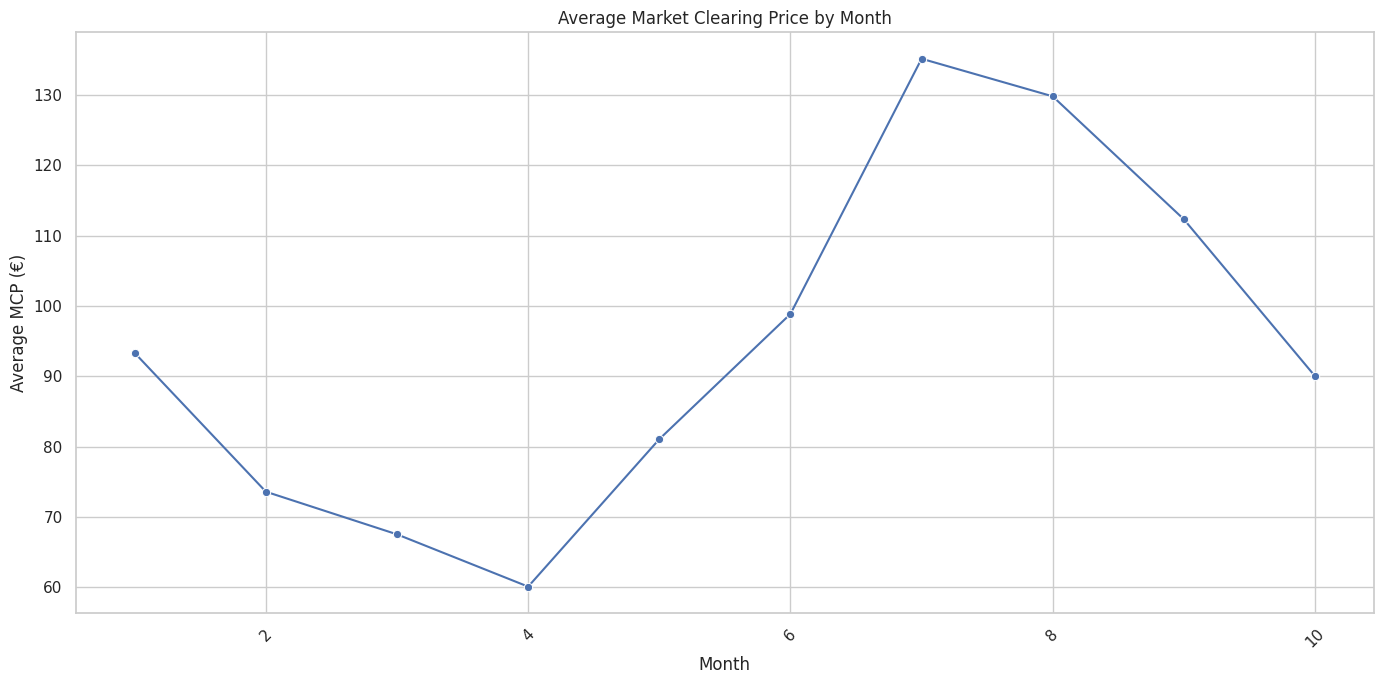

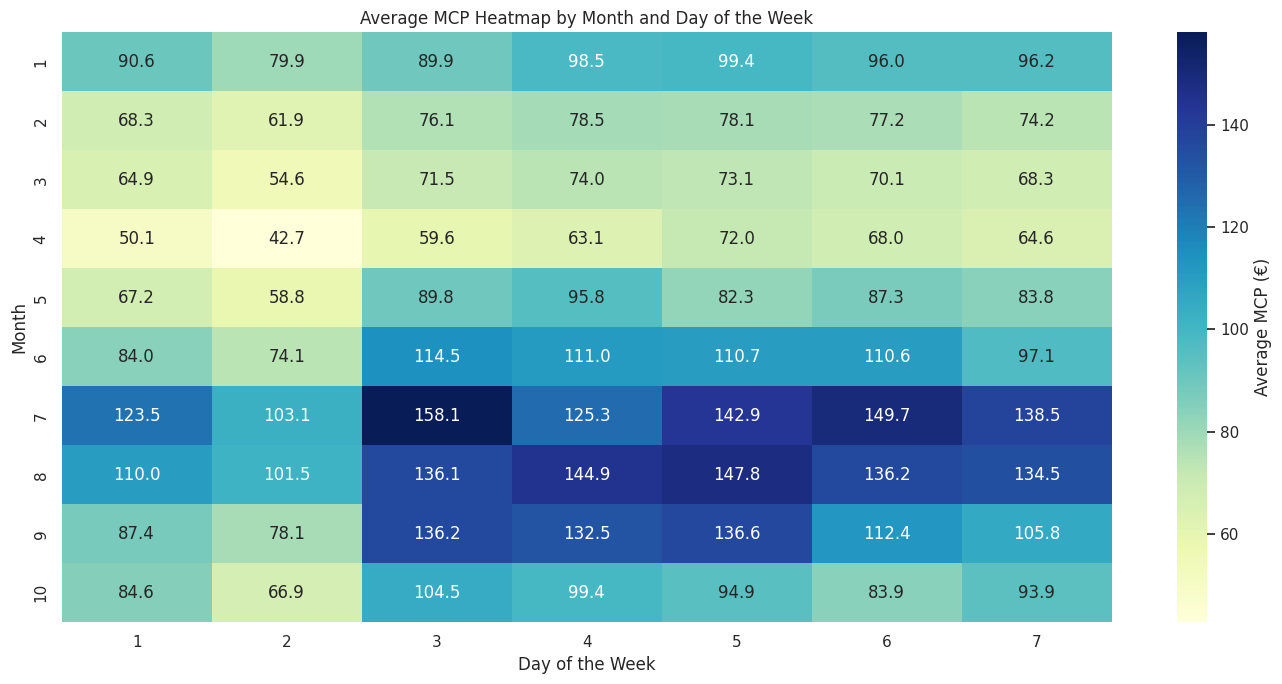

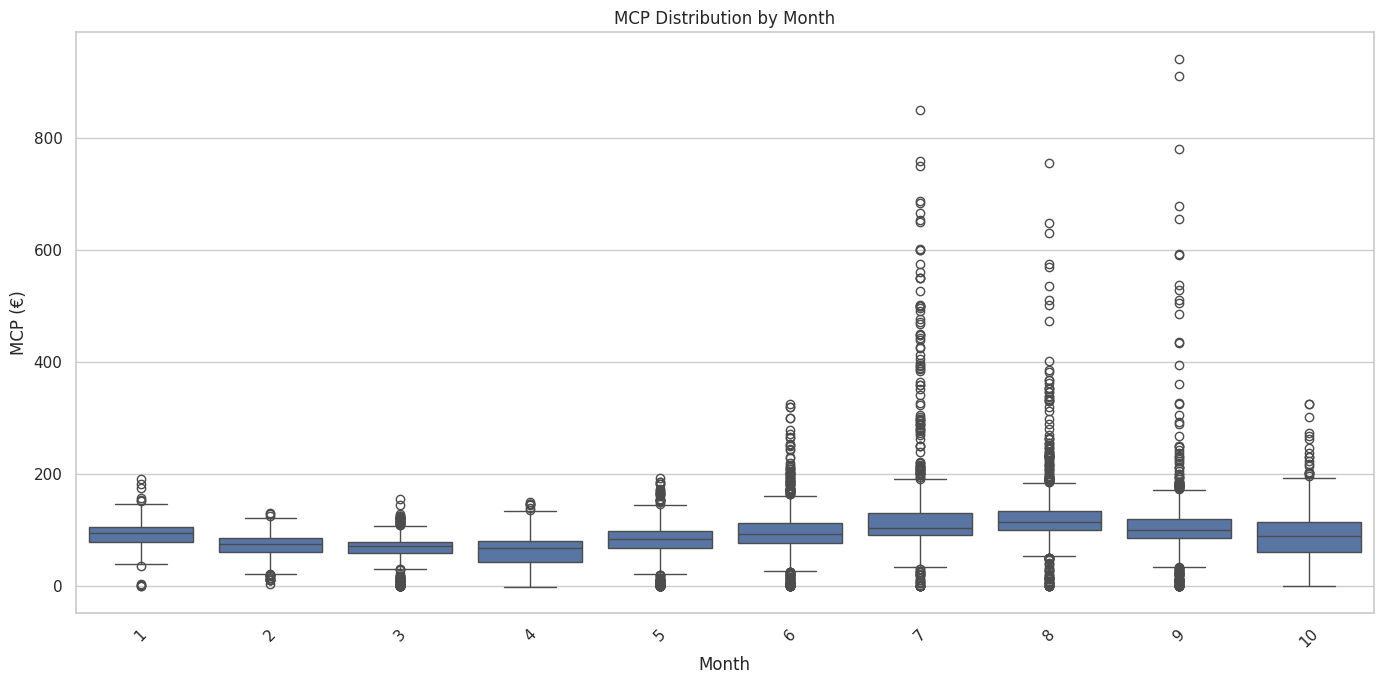

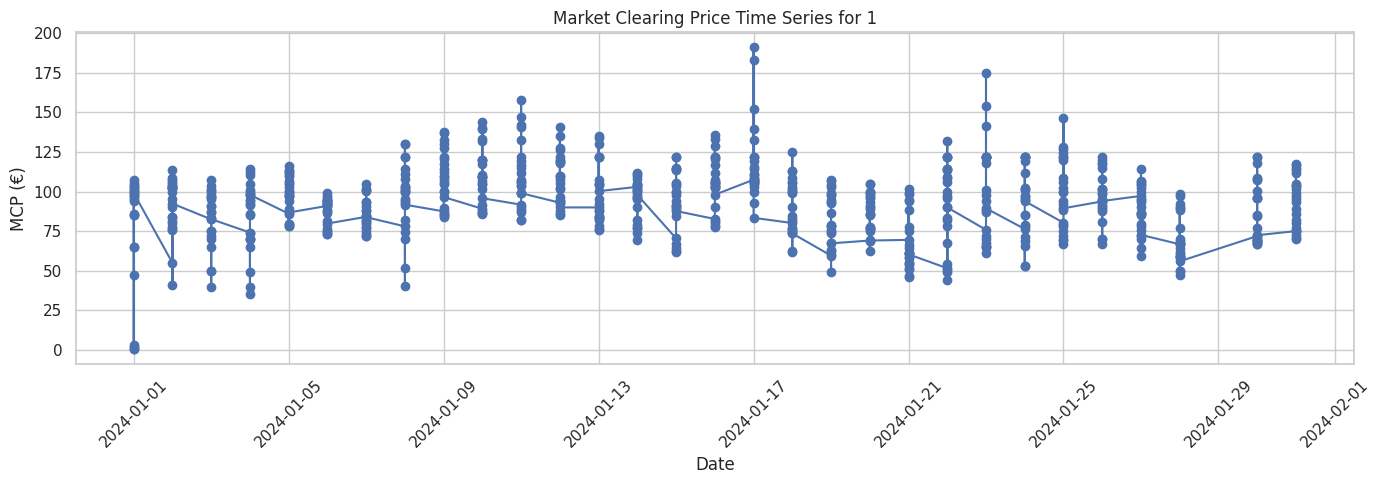

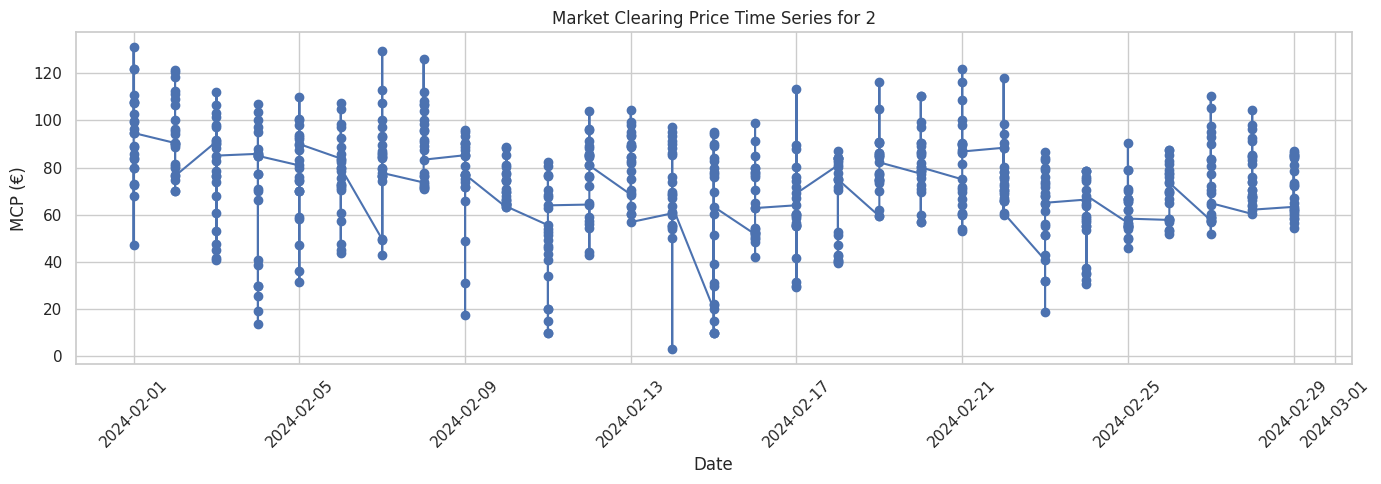

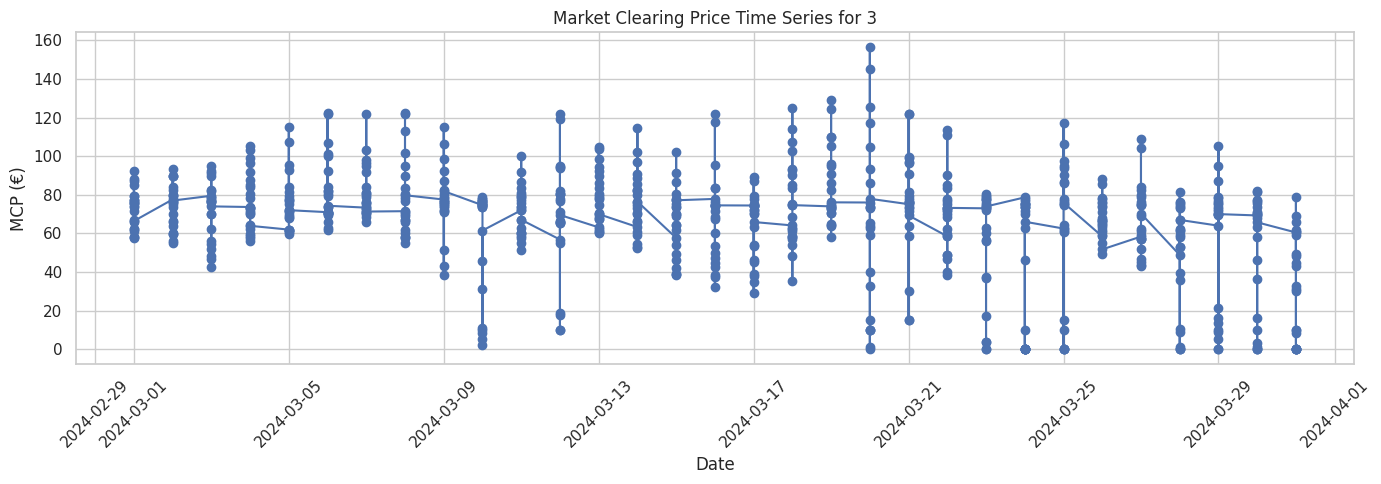

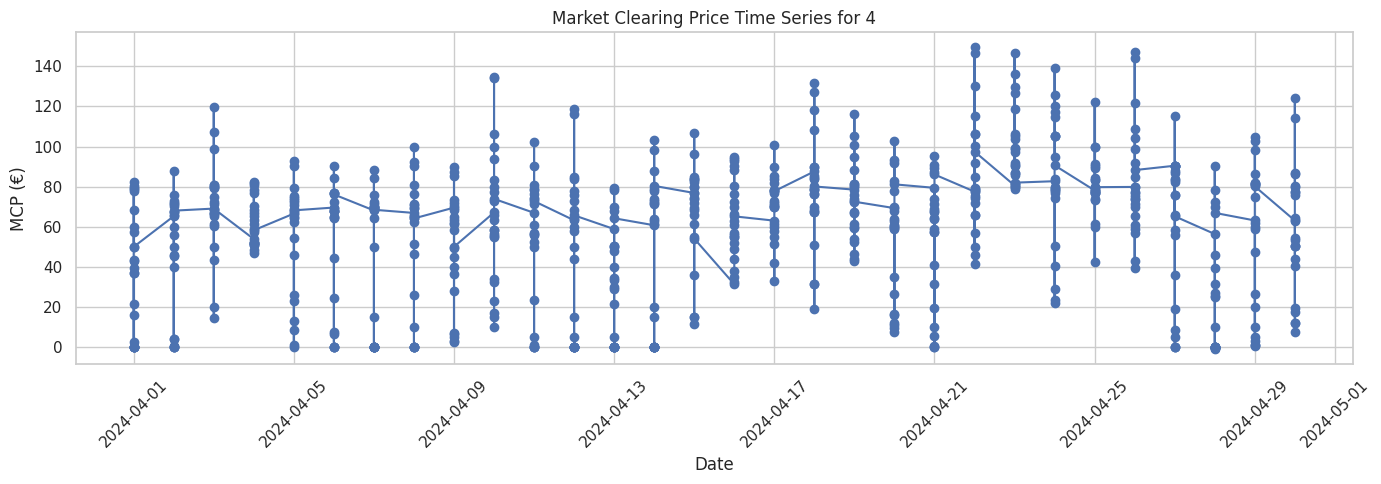

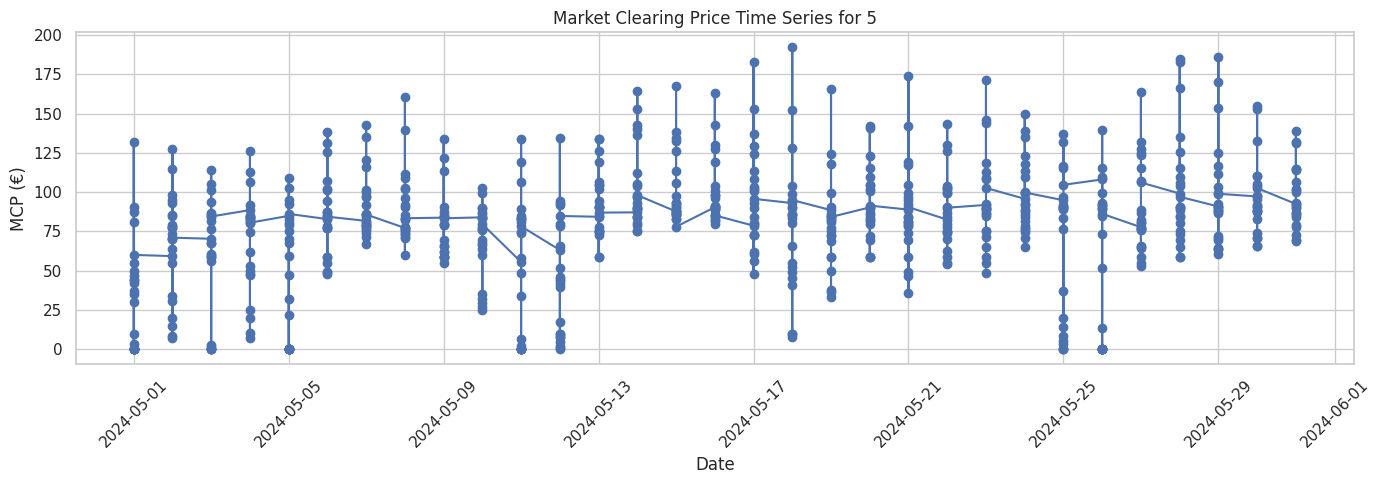

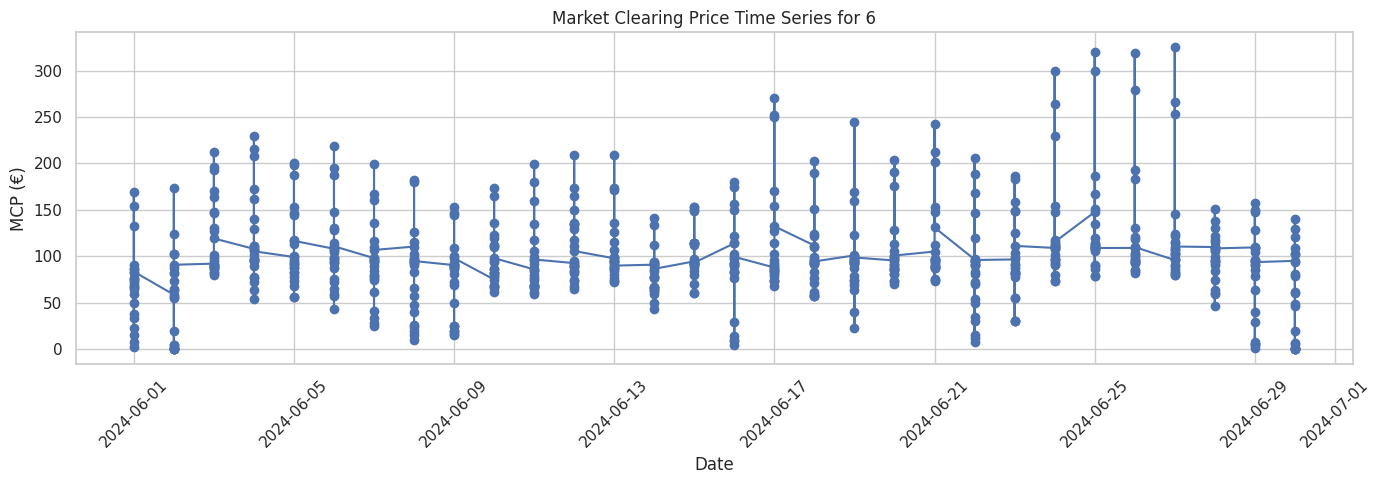

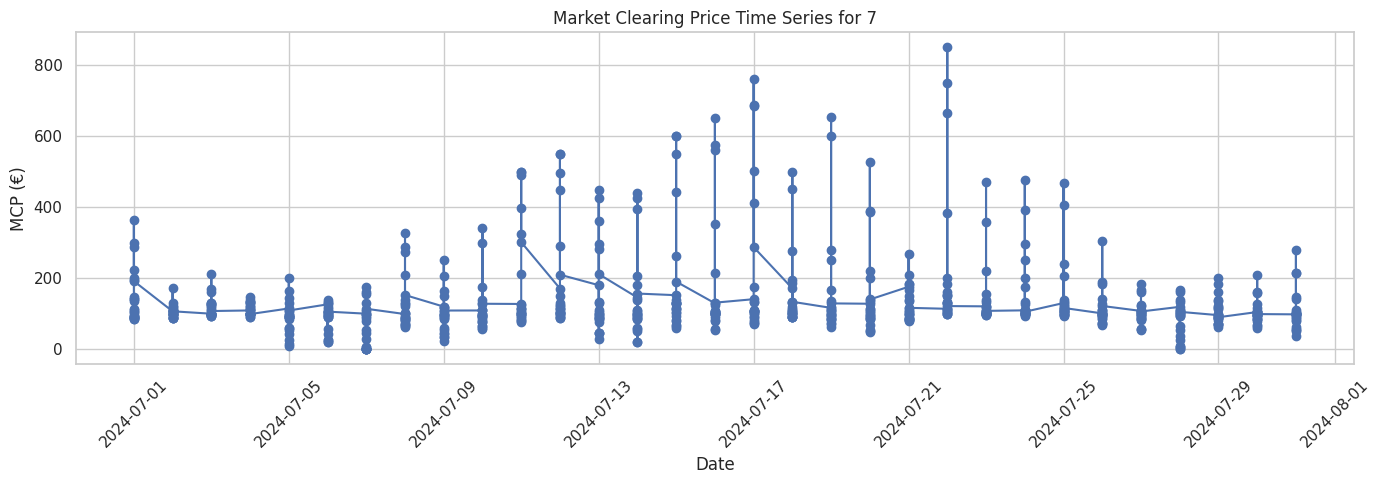

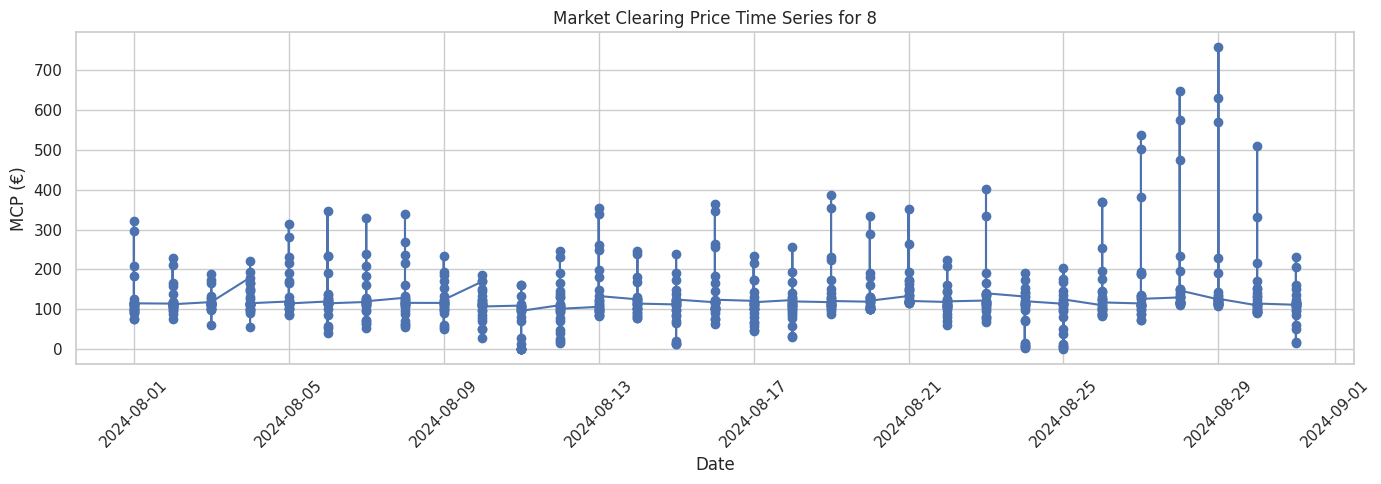

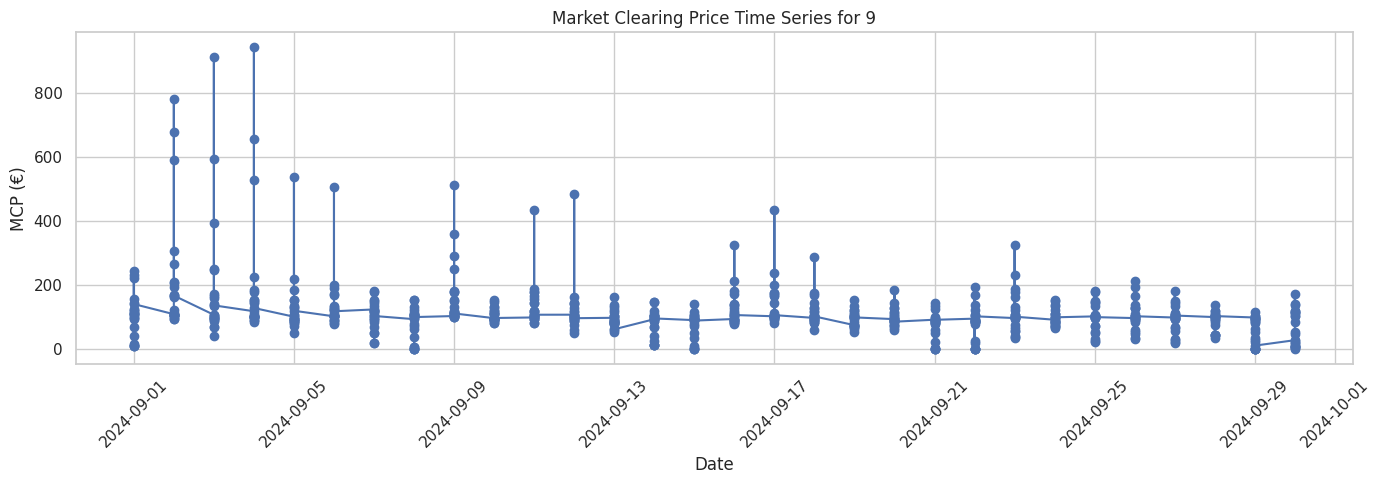

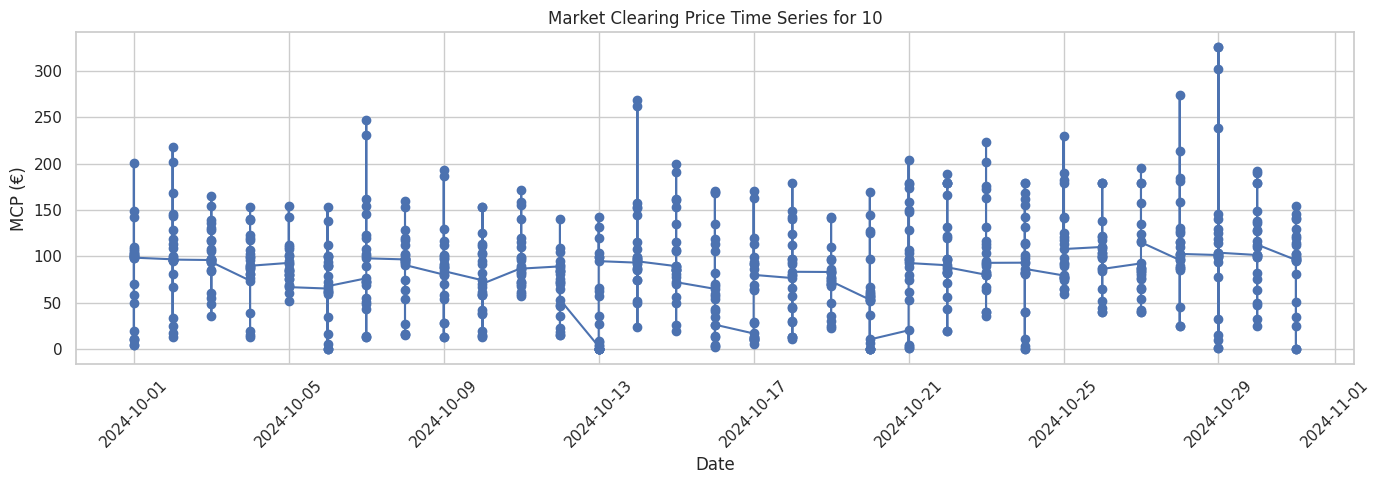

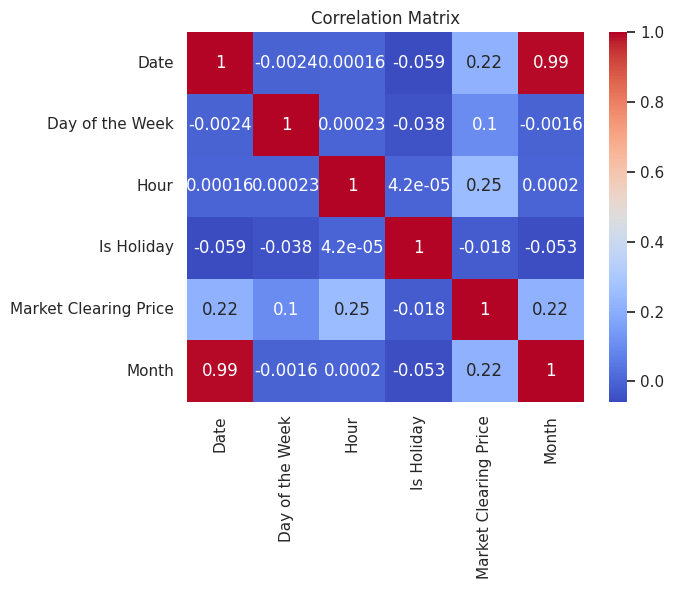

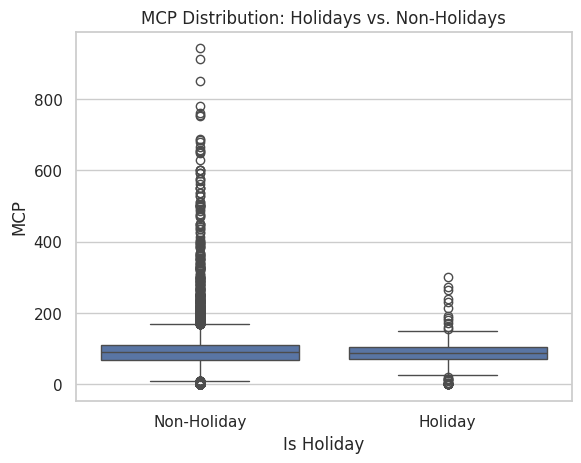

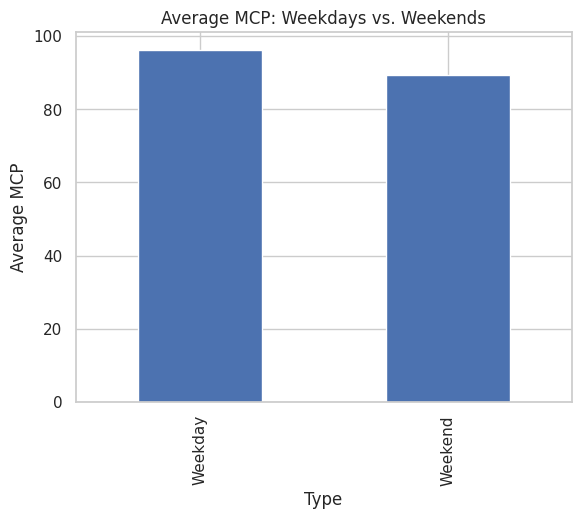

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df=combined_df_2024.copy()
df['Month'] = combined_df_2024['Date'].dt.month
# display(df)
# Calculate monthly averages for the market clearing price
monthly_avg = df.groupby('Month')['Market Clearing Price'].mean().reset_index()

# Prepare monthly data for plotting
monthly_data = df.groupby(['Month', 'Day of the Week'])['Market Clearing Price'].mean().unstack()

# Set style for plots
sns.set(style="whitegrid")

# Graph 1: Average MCP by Month
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_avg, x='Month', y='Market Clearing Price', marker='o')
plt.title('Average Market Clearing Price by Month')
plt.xlabel('Month')
plt.ylabel('Average MCP (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graph 2: Monthly Heatmap of Average MCP by Day of the Week
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_data, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Average MCP (€)'})
plt.title('Average MCP Heatmap by Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Graph 3: Box Plot of MCP for Each Month
plt.figure(figsize=(14, 7))
sns.boxplot(x='Month', y='Market Clearing Price', data=df)
plt.title('MCP Distribution by Month')
plt.xlabel('Month')
plt.ylabel('MCP (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graph 4: Time Series Plot for Each Month
for month in df['Month'].unique():
    monthly_subset = df[df['Month'] == month]
    plt.figure(figsize=(14, 5))
    plt.plot(monthly_subset['Date'], monthly_subset['Market Clearing Price'], marker='o')
    plt.title(f'Market Clearing Price Time Series for {month}')
    plt.xlabel('Date')
    plt.ylabel('MCP (€)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Graph 5: Correlation Matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Graph 6: Holidays vs. Non-Holidays
sns.boxplot(x='Is Holiday', y='Market Clearing Price', data=df)
plt.title('MCP Distribution: Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('MCP')
plt.show()

# Graph 7: Bar Plot: Weekdays vs. Weekends
df['Is Weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in [7, 1] else 0)  # Sunday=1, Saturday=7
weekend_avg = df.groupby('Is Weekend')['Market Clearing Price'].mean()
weekend_avg.plot(kind='bar', title='Average MCP: Weekdays vs. Weekends', ylabel='Average MCP', xlabel='Type')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()  # Display bar plot

#Market clearing price for 2023

In [ ]:
import os
import numpy as np
import holidays  # Import the holidays library to find Greek Holidays

# Define Greek holidays
gr_holidays = holidays.Greece()

# Define folder path where all Excel files are located
folder_path = '/content/drive/MyDrive/Day-Ahead-Market-Data/2023_EL-DAM_ResultsSummary'

# Initialize a list to store each file's hourly data
all_data = []
rows_with_na_accumulated = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df_market_price_hourly = {}

        try:
            # Load the workbook and sheet
            workbook = openpyxl.load_workbook(file_path)
            sheet = workbook['MKT_Coupling']

            # Unfreeze panes and clear filters if any exist
            sheet.freeze_panes = None
            if sheet.auto_filter.ref:
                sheet.auto_filter.ref = None

            # Save any changes
            workbook.save(file_path)

            # Load the DataFrame, skipping the first row and using the second row as header
            df = pd.read_excel(file_path, sheet_name='MKT_Coupling', header=1)
            df.dropna(axis=1, how='all', inplace=True)
            df_cleaned = df[~df.iloc[:, 0].str.contains("Day-Ahead Market Coupling Results", na=False)]
            df_cleaned.dropna(how='all', inplace=True)
            df_cleaned.reset_index(drop=True, inplace=True)

            # Get the date value from the specified cell
            Date = sheet.cell(row=2, column=1).value  # Extract date from cell (e.g., B2) (where the date is located in the file)

            # Drop the 25th column if it exists
            if df_cleaned.shape[1] >= 26:
                df_cleaned.drop(df_cleaned.columns[25], axis=1, inplace=True)


            # Convert columns to numeric where possible without replacing 0.00 or 0.01
            for col in df_cleaned.columns[1:]:
                # Ensure that only non-numeric values (like strings) are converted to NaN
                df_cleaned[col] = pd.to_numeric(df_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

            # Find and accumulate rows with NaN or pd.NA values
            rows_with_na = df_Hourly[df_Hourly.isna().any(axis=1)]
            rows_with_na_accumulated = pd.concat([rows_with_na_accumulated, rows_with_na])

            # Replace NaN or pd.NA values with 0, keeping small decimals intact
            df_Hourly = df_Hourly.map(lambda x: 0 if pd.isna(x) else x)

            # Define starting row indices for sections
            start_market_price = df_cleaned[df_cleaned.iloc[:, 0] == 'Market Clearing Price'].index[0]
            start_imports_implicit = df_cleaned[df_cleaned.iloc[:, 0] == 'BORDER IMPORTS (IMPLICIT)'].index[0]

            # Extract the 'Market Clearing Price' section
            df_market_price = df_cleaned.iloc[start_market_price:start_imports_implicit].dropna(how='all')
            df_market_price.set_index(df_market_price.columns[0], inplace=True)

            # Collect hourly data only if there are enough columns
            for Hour in range(1, min(25, df_market_price.shape[1] + 1)):  # Ensure we don't exceed available columns
                Hourly_data = df_market_price.iloc[:, Hour - 1]  # Get data for the Hour
                df_market_price_hourly[(Date, Hour)] = Hourly_data

            # Convert hourly data dictionary to a DataFrame
            df_Hourly = pd.DataFrame(df_market_price_hourly).T
            df_Hourly.index.names = ['Date', 'Hour']
            df_Hourly.reset_index(inplace=True)

            # Add "Day of the Week" column as an integer (1 for Sunday, 2 for Monday, etc.)
            df_Hourly['Day of the Week'] = df_Hourly['Date'].apply(lambda x: (x.weekday() + 2) % 7 + 1)

            # Add "Is Holiday" column based on Greek public holidays
            df_Hourly['Is Holiday'] = df_Hourly['Date'].apply(lambda x: 1 if x in gr_holidays else 0)

            # Reorder the columns to make "Day of the Week" the second column
            df_Hourly = df_Hourly[['Date', 'Day of the Week', 'Hour', 'Is Holiday'] +
                                  [col for col in df_Hourly.columns if col not in ['Date', 'Day of the Week', 'Hour', 'Is Holiday']]]

            # Replace any missing or invalid values and sort
            df_Hourly.replace(['', 'NaN', 'nan'], pd.NA, inplace=True)
            df_Hourly.fillna(0, inplace=True)

            # Append to the all_data list
            all_data.append(df_Hourly)

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Concatenate all DataFrames into a single DataFrame and sort by Date and Hour
if all_data:  # Check if there is any data to concatenate
    combined_df_2023 = pd.concat(all_data, ignore_index=True)
    combined_df_2023.sort_values(by=['Date', 'Hour'], inplace=True) #Sort data by Date and Hour
    combined_df_2023 .reset_index(drop=True, inplace=True)
    if combined_df_2023 .shape[1] >= 2:  # Ensure there are at least two columns
        combined_df_2023 .drop(combined_df_2023 .columns[-2], axis=1, inplace=True)

    # Rename the last column to 'Market Clearing Price'
    combined_df_2023 .rename(columns={combined_df_2023 .columns[-1]: 'Market Clearing Price'}, inplace=True)

    # Display the final combined DataFrame
    print("\nCombined Market Clearing Price Data:")
    display(combined_df_2023)
else:
    print("No valid data to display.")

display(rows_with_na_accumulated)


Combined Market Clearing Price Data:


Date  Day of the Week  Hour  Is Holiday  Market Clearing Price
0    2023-01-01                2     1           1                 230.90
1    2023-01-01                2     2           1                 268.19
2    2023-01-01                2     3           1                 229.58
3    2023-01-01                2     4           1                 235.98
4    2023-01-01                2     5           1                 234.28
...         ...              ...   ...         ...                    ...
8754 2023-12-31                2    20           0                 123.82
8755 2023-12-31                2    21           0                 129.03
8756 2023-12-31                2    22           0                 117.23
8757 2023-12-31                2    23           0                 108.96
8758 2023-12-31                2    24           0                 106.12

[8759 rows x 5 columns]

Empty DataFrame
Columns: [Date, Day of the Week, Hour, Is Holiday, Market Clearing Price, Greece Mainland]
Index: []

In [ ]:
df= combined_df_2023.copy()
zero_values = df[df['Market Clearing Price'] == 0]
print(zero_values)
zero_count = (df['Market Clearing Price'] == 0).sum()
print(f"Total rows with zero Market Clearing Price: {zero_count}")

           Date  Day of the Week  Hour  Is Holiday  Market Clearing Price
3348 2023-05-20                1    14           0                    0.0
3349 2023-05-20                1    15           0                    0.0
3350 2023-05-20                1    16           0                    0.0
3536 2023-05-28                2    10           0                    0.0
3537 2023-05-28                2    11           0                    0.0
3538 2023-05-28                2    12           0                    0.0
3539 2023-05-28                2    13           0                    0.0
3540 2023-05-28                2    14           0                    0.0
3541 2023-05-28                2    15           0                    0.0
3542 2023-05-28                2    16           0                    0.0
4376 2023-07-02                2    10           0                    0.0
4380 2023-07-02                2    14           0                    0.0
4381 2023-07-02                2    15

In [ ]:
# Set 'Date' as the index if it's not already, and ensure it is a DateTimeIndex
df= combined_df_2023.copy()
# Combine Date and Hour into a single DateTime column if they are separate
df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
df = df.set_index('DateTime').sort_index()

# Now reindex to find missing hourly entries
expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # Use lowercase 'h' for hours
df_reindexed = df.reindex(expected_dates)
missing_rows = df_reindexed[df_reindexed.isnull().any(axis=1)]
print("Missing dates and times:")
print(missing_rows)

Missing dates and times:
           Date  Day of the Week  Hour  Is Holiday  Market Clearing Price
2023-03-27  NaT              NaN   NaN         NaN                    NaN


In [ ]:
combined_df_2023.to_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_MarketPrice_df_2023.csv')

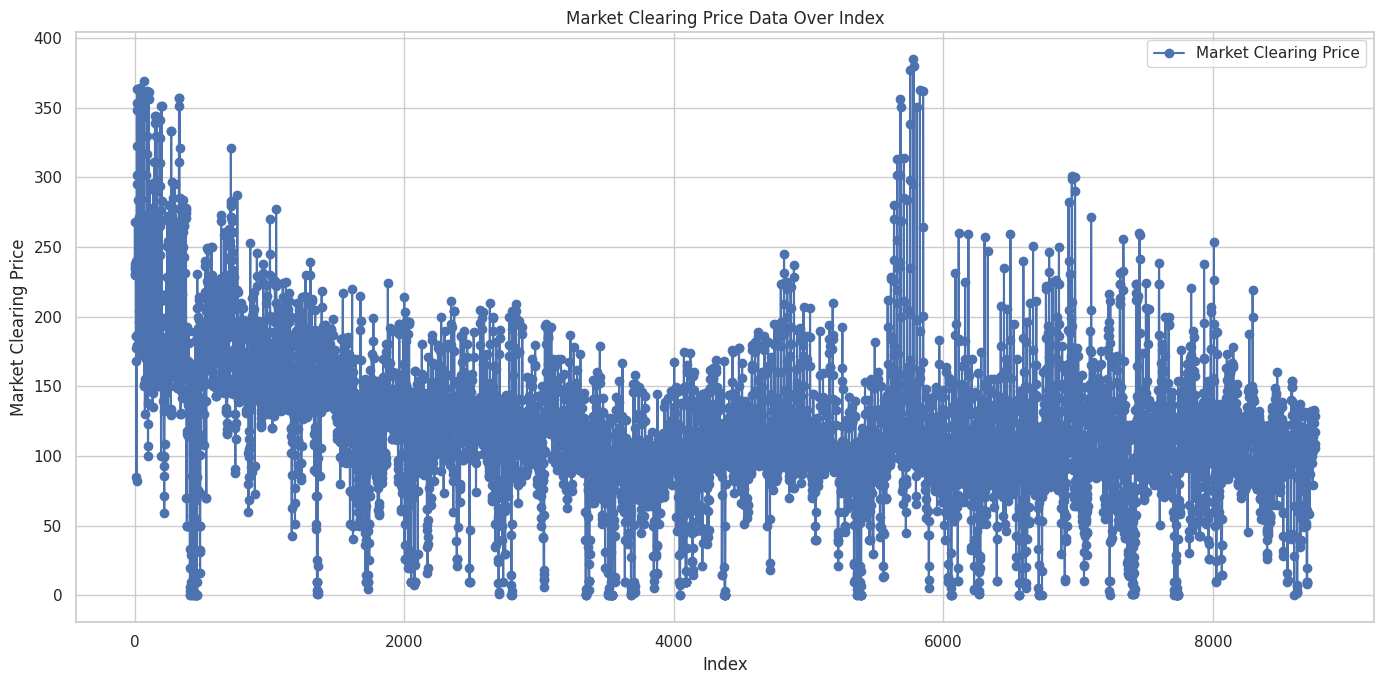

In [ ]:
import matplotlib.pyplot as plt

# Plotting the 'Market Clearing Price'd data using index for x-axis
plt.figure(figsize=(14, 7))
plt.plot(combined_df_2023.index, combined_df_2023['Market Clearing Price'], marker='o', linestyle='-', color='b',  label='Market Clearing Price')

# Adding titles and labels
plt.title('Market Clearing Price Data Over Index')
plt.xlabel('Index')
plt.ylabel('Market Clearing Price')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

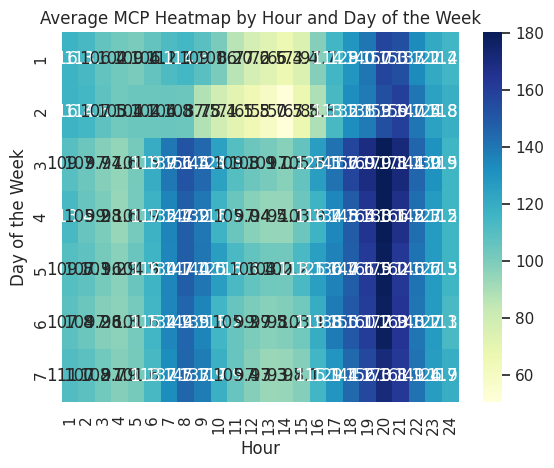

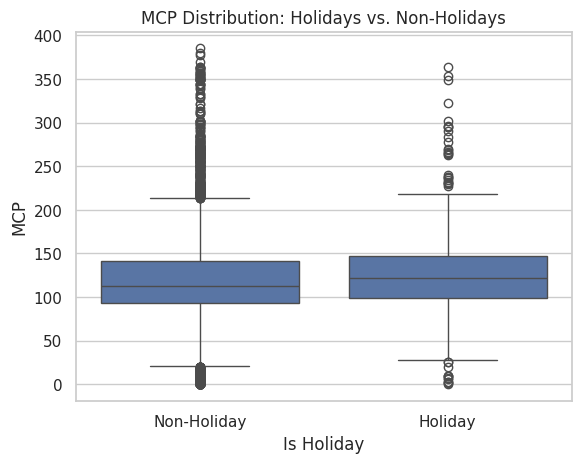

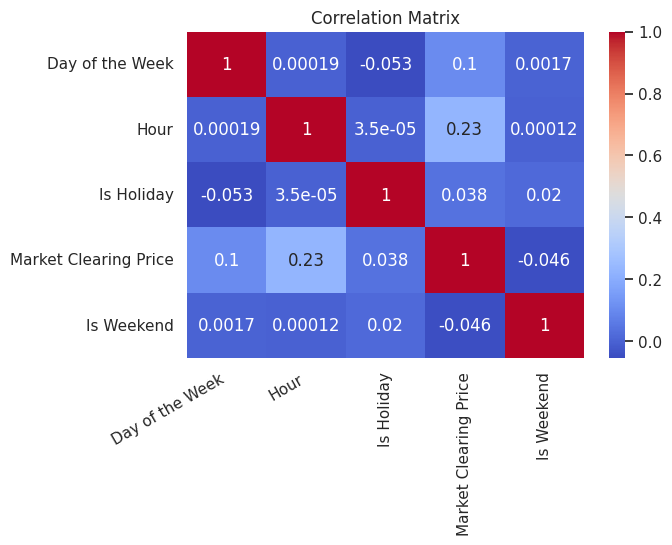

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df=combined_df_2023.copy()

hourly_avg = df.groupby('Hour')['Market Clearing Price'].mean()
hourly_avg.plot(kind='line', title='Average MCP by Hour', xlabel='Hour', ylabel='Average MCP')

###############
heatmap_data = df.pivot_table(values='Market Clearing Price', index='Day of the Week', columns='Hour', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average MCP Heatmap by Hour and Day of the Week')
plt.xlabel('Hour')
plt.ylabel('Day of the Week')
plt.show()
#####################
sns.boxplot(x='Is Holiday', y='Market Clearing Price', data=df)
plt.title('MCP Distribution: Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('MCP')
plt.show()
######################
df['Is Weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in [7, 1] else 0)  # Assuming 6=Saturday, 7=Sunday
weekend_avg = df.groupby('Is Weekend')['Market Clearing Price'].mean()
weekend_avg.plot(kind='bar', title='Average MCP: Weekdays vs. Weekends', ylabel='Average MCP', xlabel='Type')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
########################
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Market Clearing Price'].plot(title='Market Clearing Price Over Time', xlabel='Date', ylabel='MCP')
##################
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Date  Day of the Week  Hour  Is Holiday  Market Clearing Price  \
0    2023-01-01                2     1           1                 230.90   
1    2023-01-01                2     2           1                 268.19   
2    2023-01-01                2     3           1                 229.58   
3    2023-01-01                2     4           1                 235.98   
4    2023-01-01                2     5           1                 234.28   
...         ...              ...   ...         ...                    ...   
8754 2023-12-31                2    20           0                 123.82   
8755 2023-12-31                2    21           0                 129.03   
8756 2023-12-31                2    22           0                 117.23   
8757 2023-12-31                2    23           0                 108.96   
8758 2023-12-31                2    24           0                 106.12   

      Month  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
8754     12  
8755     12  
8756     12  
8757     12  
8758     12  

[8759 rows x 6 columns]

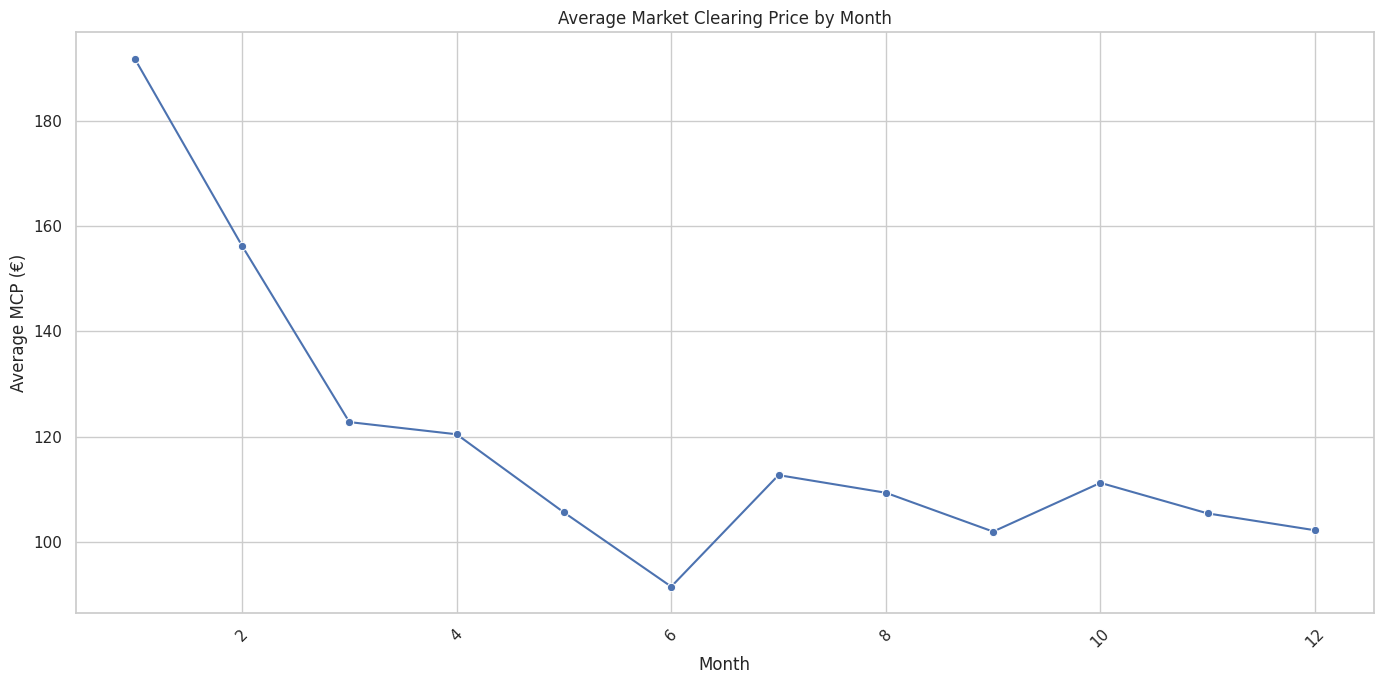

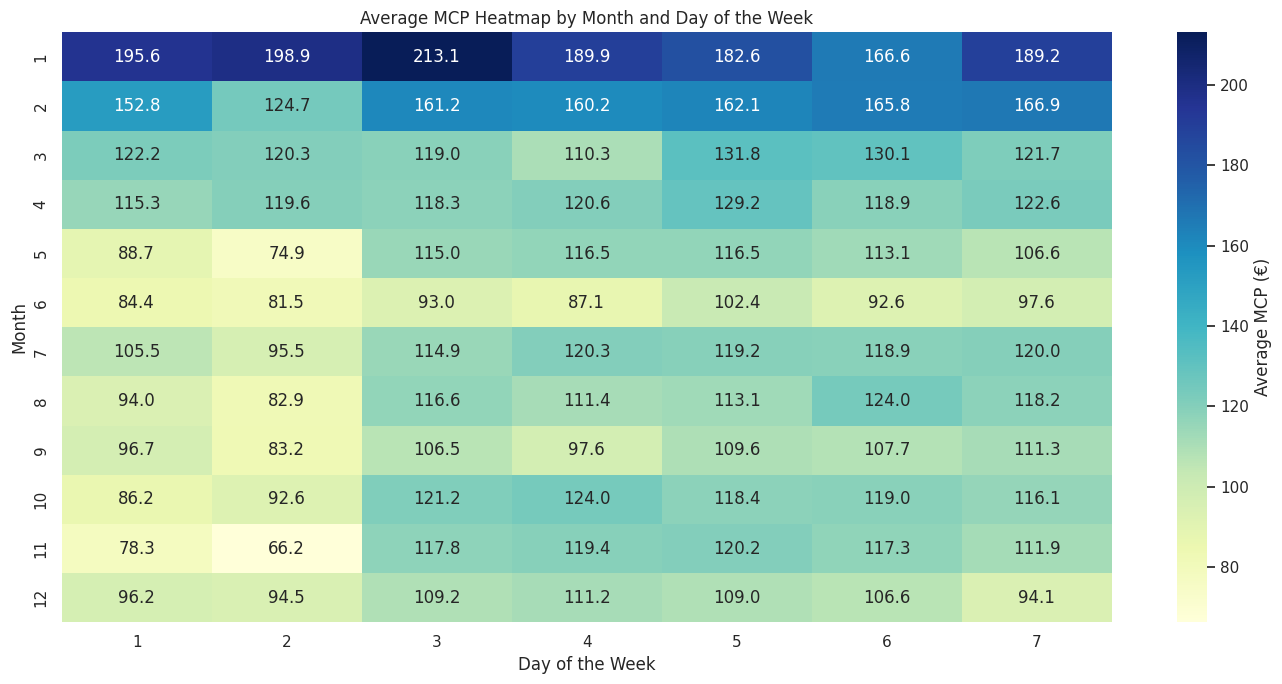

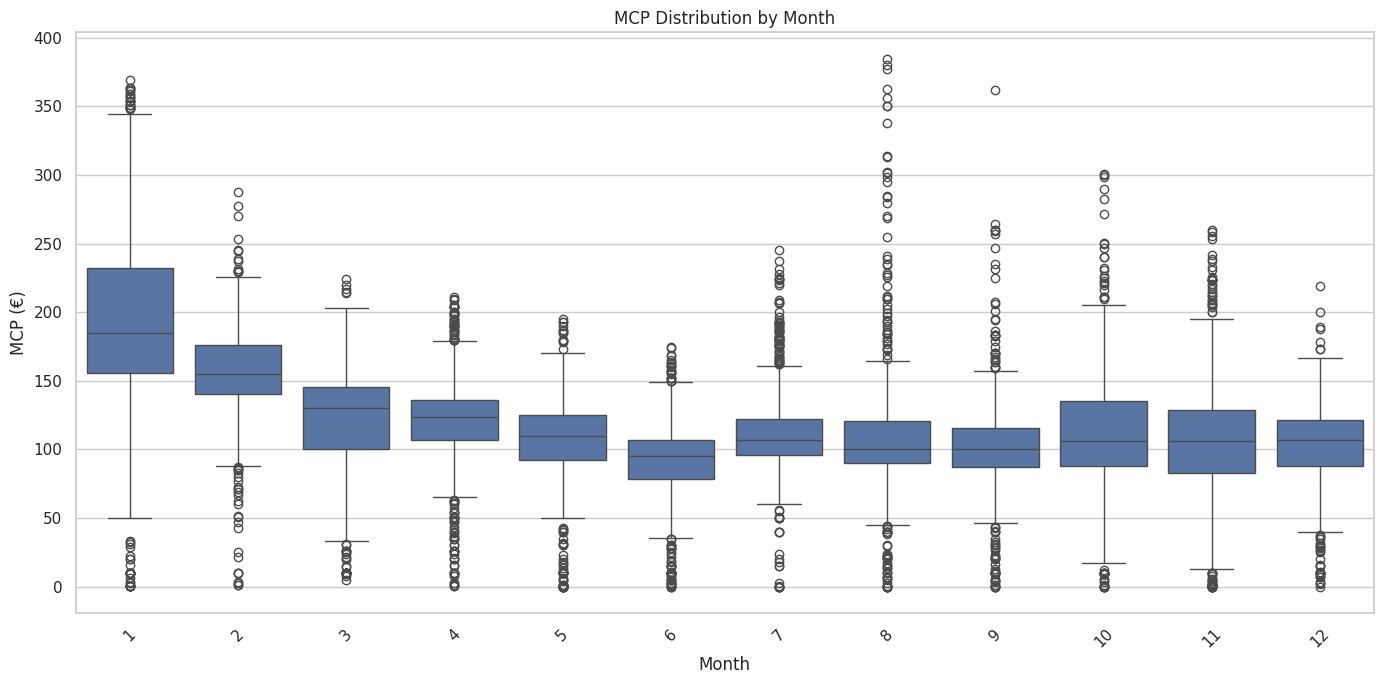

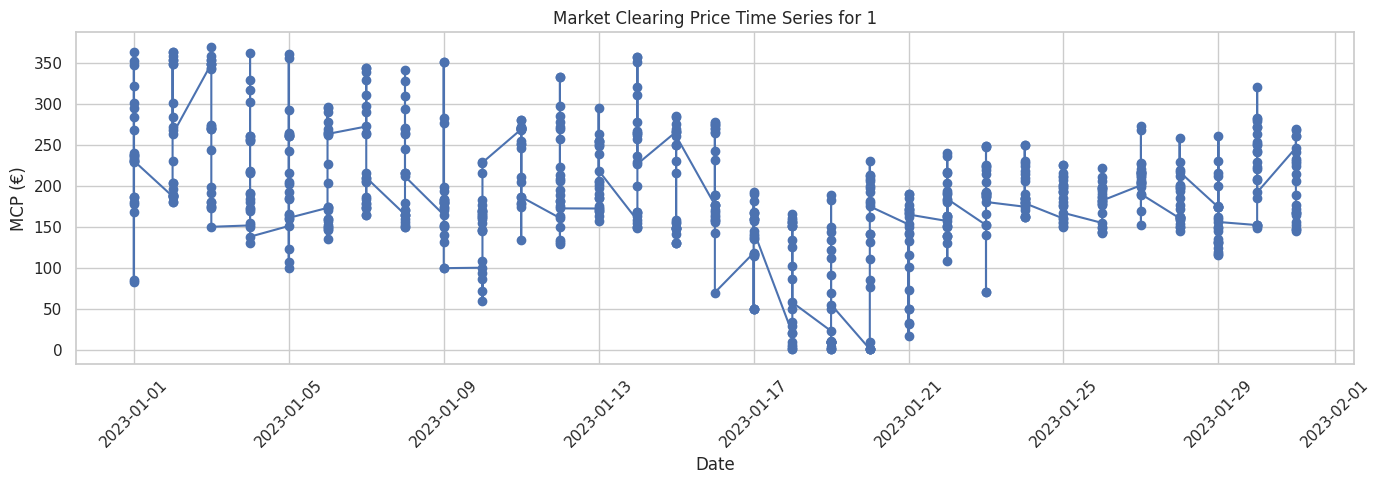

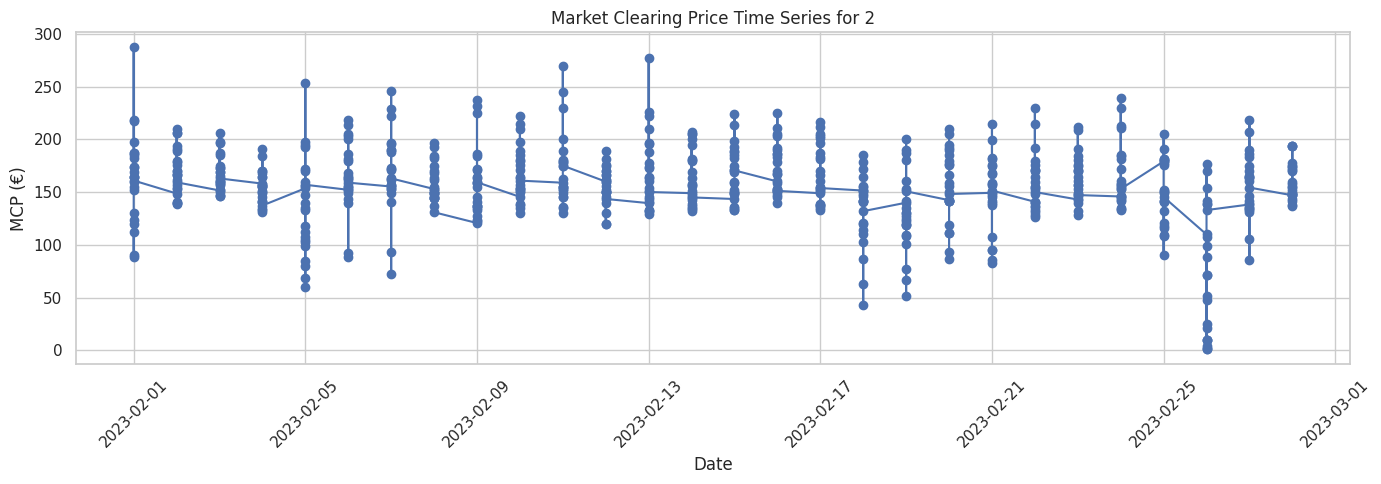

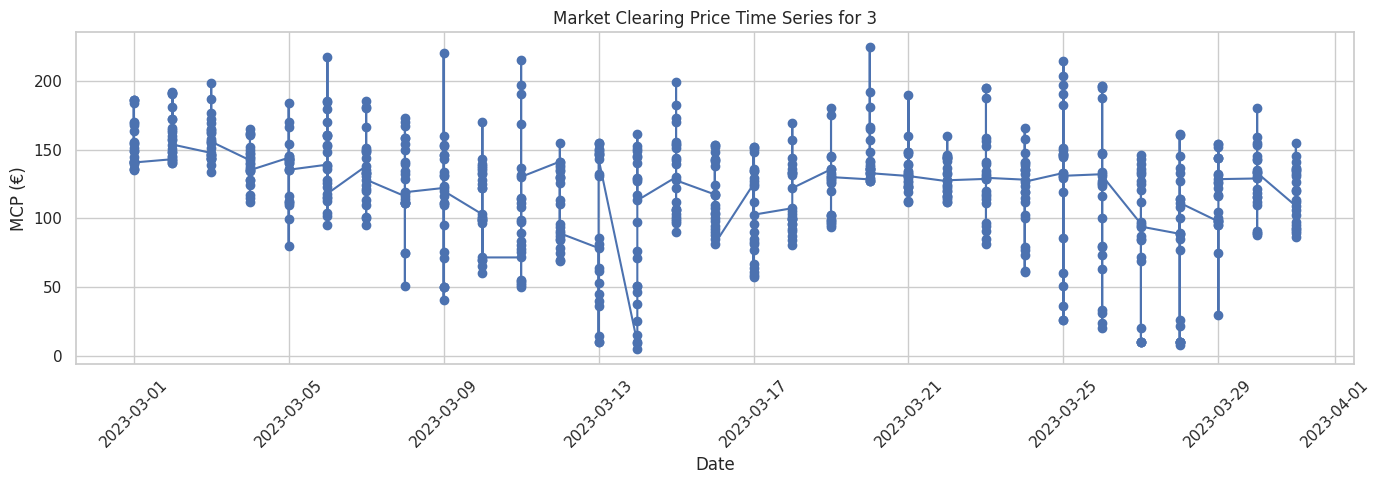

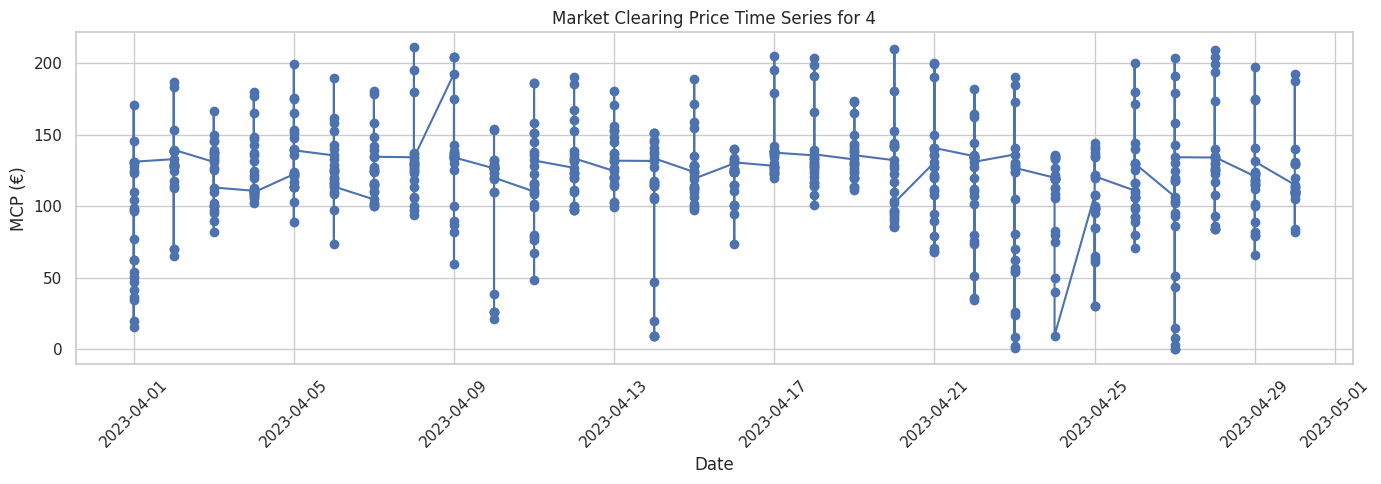

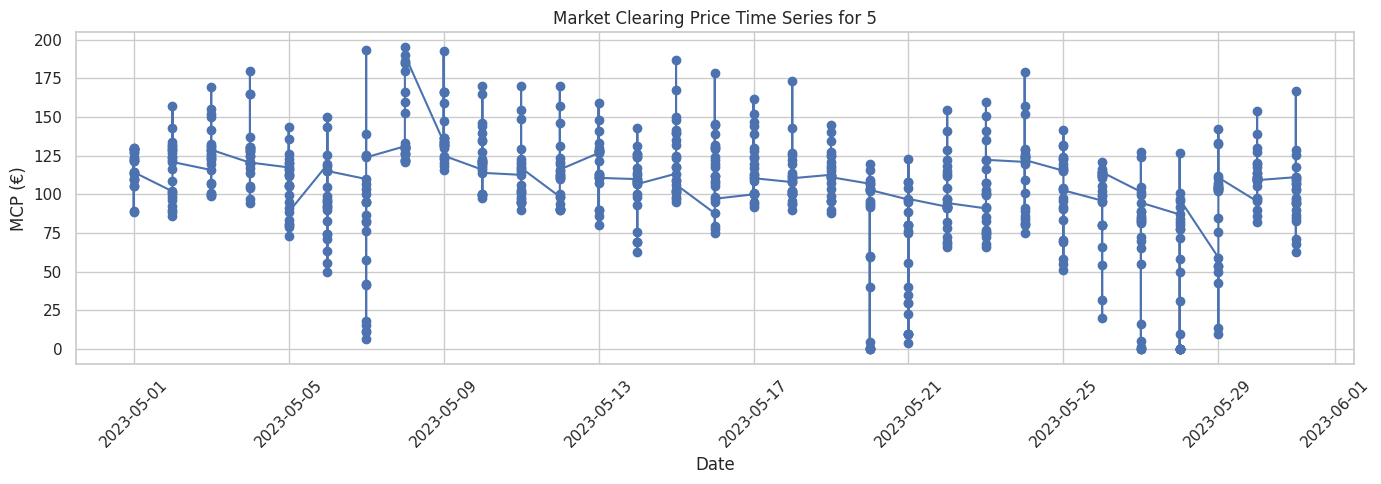

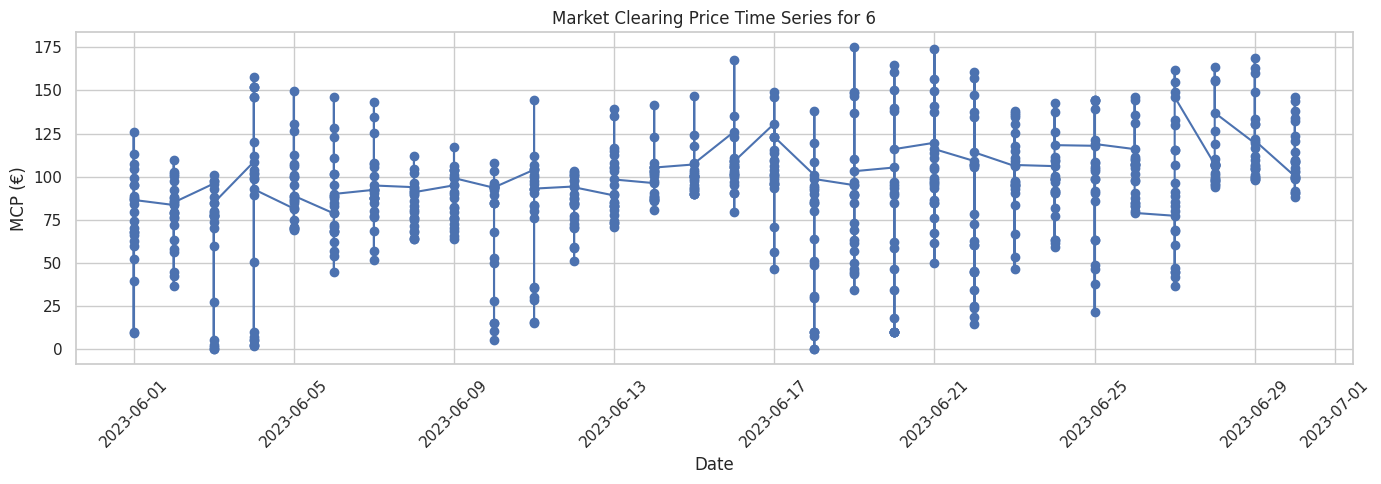

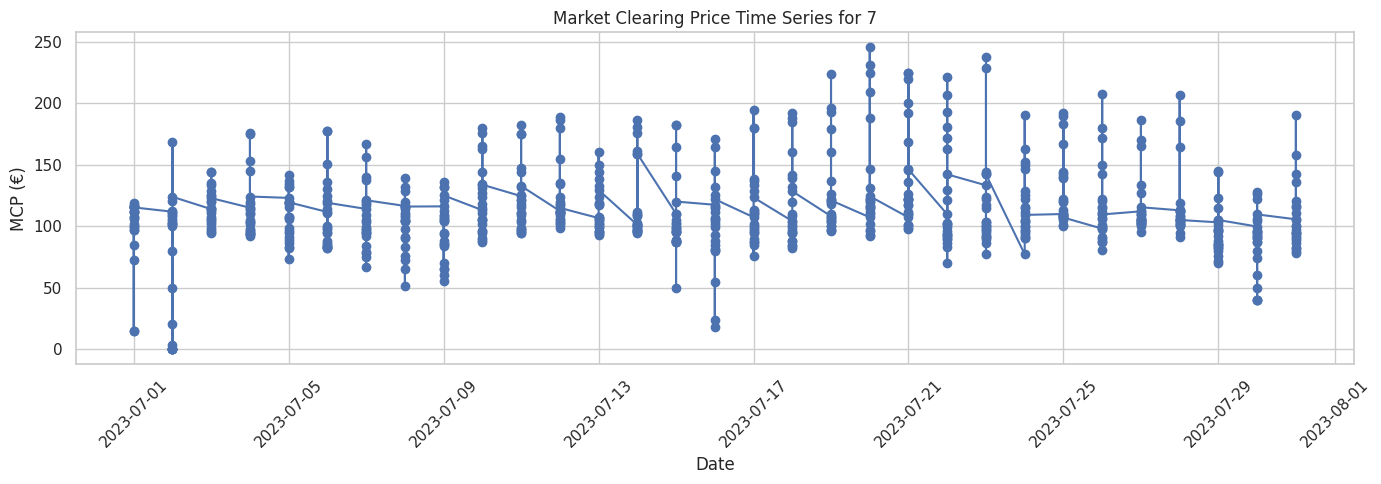

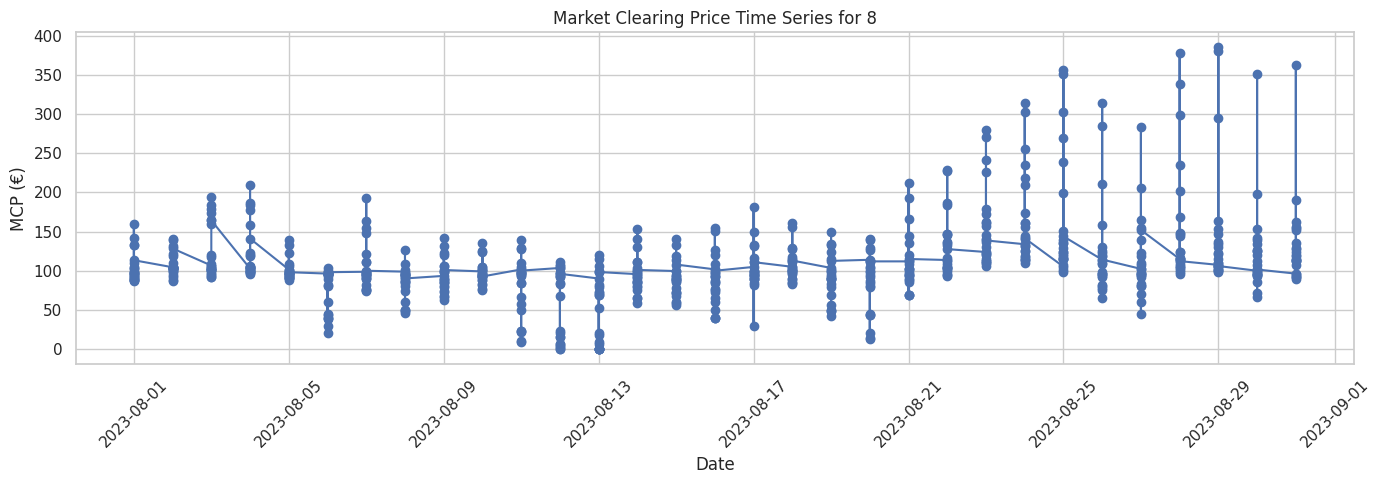

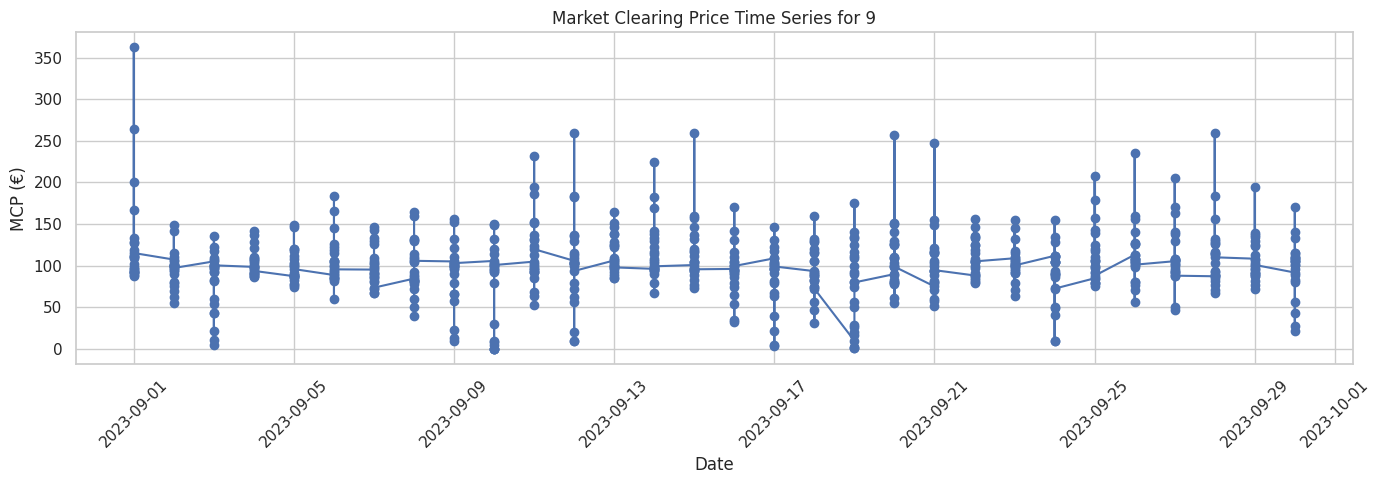

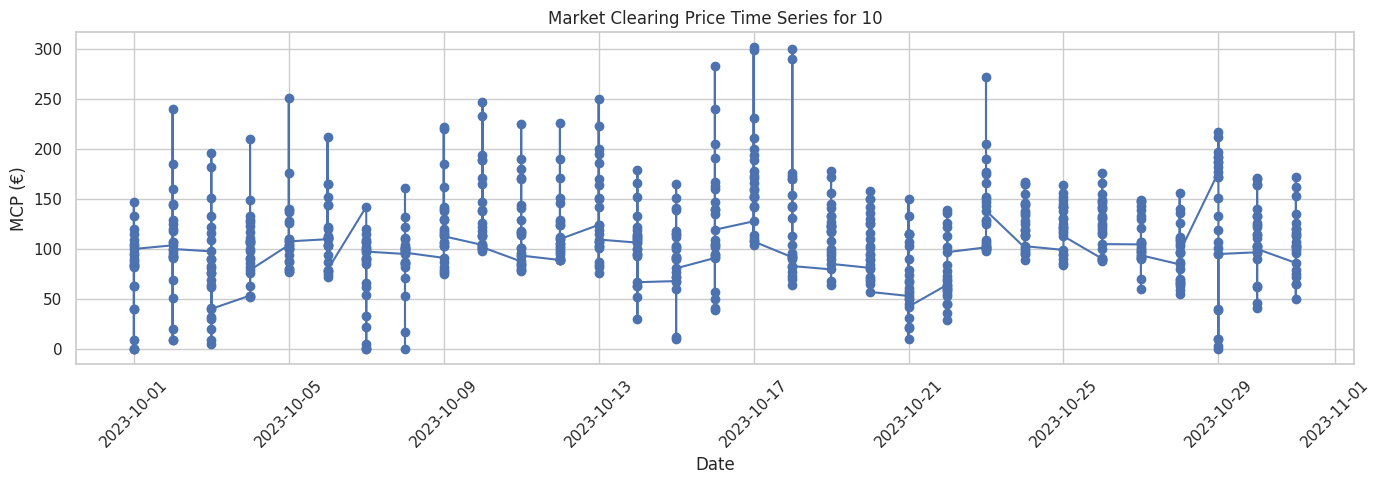

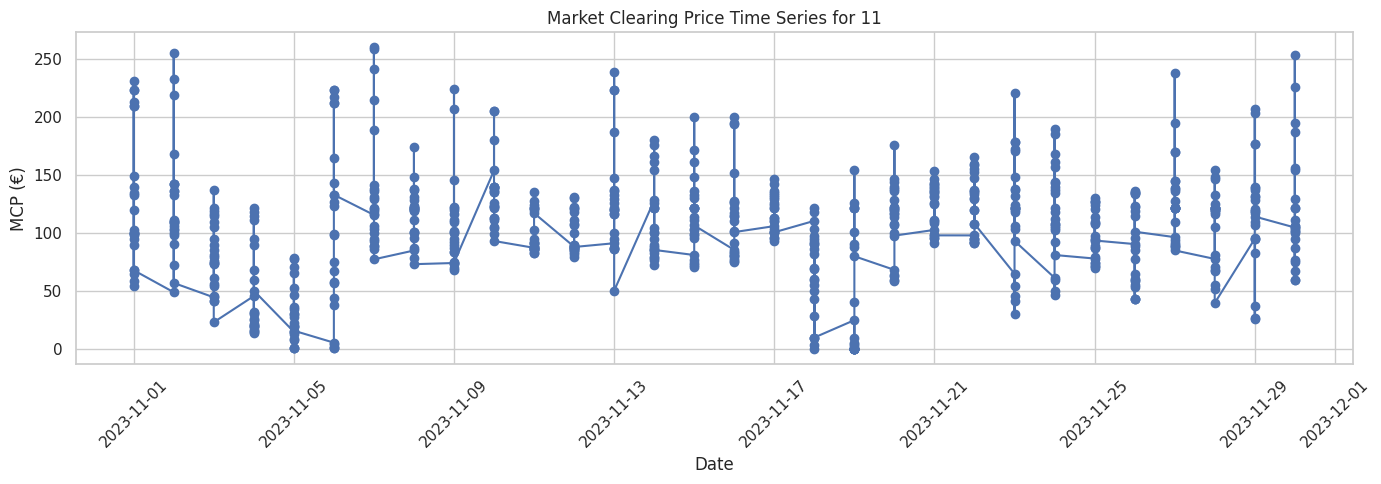

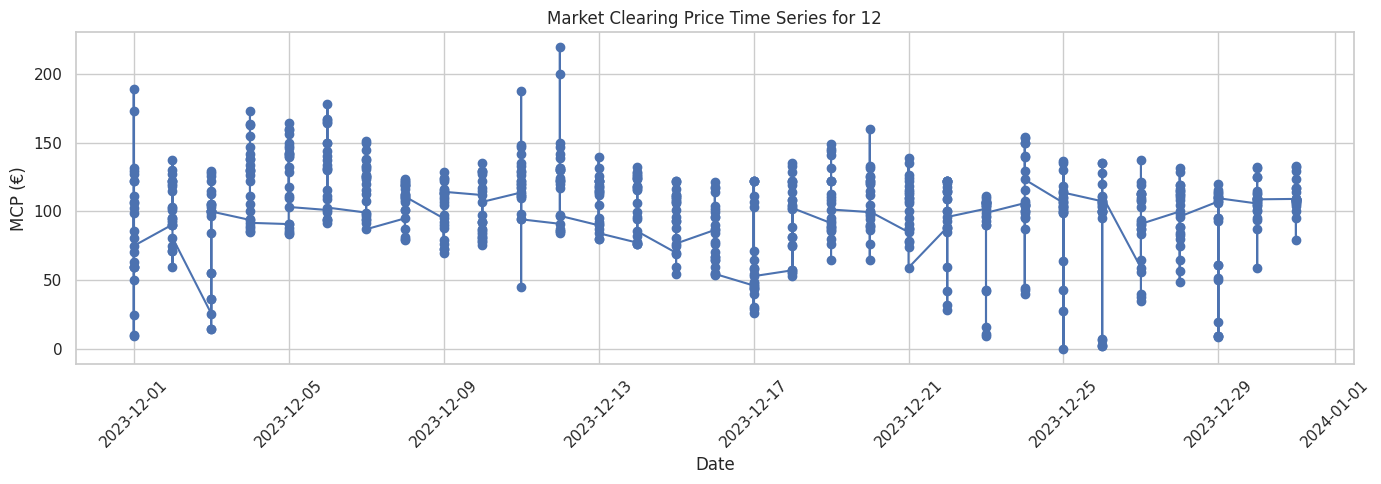

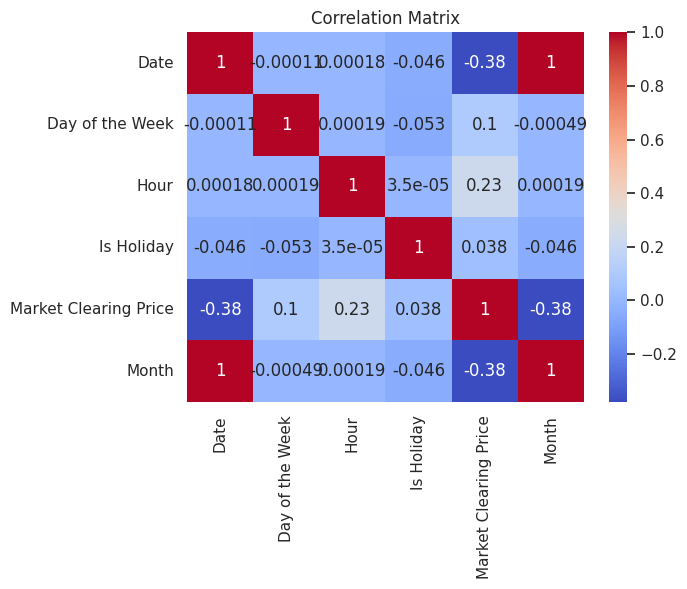

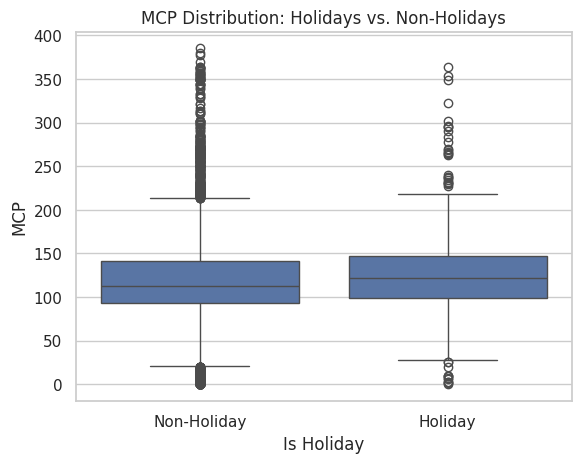

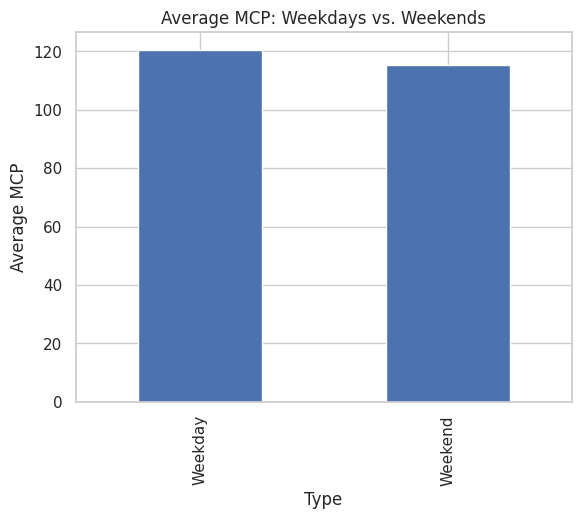

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=combined_df_2023.copy()
# Assuming combined_df is your DataFrame with a 'Date' column already in datetime format
df['Month'] = df['Date'].dt.month
display(df)
# Calculate monthly averages for the market clearing price
monthly_avg = df.groupby('Month')['Market Clearing Price'].mean().reset_index()

# Prepare monthly data for plotting
monthly_data = df.groupby(['Month', 'Day of the Week'])['Market Clearing Price'].mean().unstack()

# Set style for plots
sns.set(style="whitegrid")

# Graph 1: Average MCP by Month
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_avg, x='Month', y='Market Clearing Price', marker='o')
plt.title('Average Market Clearing Price by Month')
plt.xlabel('Month')
plt.ylabel('Average MCP (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graph 2: Monthly Heatmap of Average MCP by Day of the Week
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_data, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Average MCP (€)'})
plt.title('Average MCP Heatmap by Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Graph 3: Box Plot of MCP for Each Month
plt.figure(figsize=(14, 7))
sns.boxplot(x='Month', y='Market Clearing Price', data=df)
plt.title('MCP Distribution by Month')
plt.xlabel('Month')
plt.ylabel('MCP (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graph 4: Time Series Plot for Each Month
for month in df['Month'].unique():
    monthly_subset = df[df['Month'] == month]
    plt.figure(figsize=(14, 5))
    plt.plot(monthly_subset['Date'], monthly_subset['Market Clearing Price'], marker='o')
    plt.title(f'Market Clearing Price Time Series for {month}')
    plt.xlabel('Date')
    plt.ylabel('MCP (€)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Graph 5: Correlation Matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Graph 6: Holidays vs. Non-Holidays
sns.boxplot(x='Is Holiday', y='Market Clearing Price', data=df)
plt.title('MCP Distribution: Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('MCP')
plt.show()

# Graph 7: Bar Plot: Weekdays vs. Weekends
df['Is Weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in [7, 1] else 0)  # Sunday=1, Saturday=7
weekend_avg = df.groupby('Is Weekend')['Market Clearing Price'].mean()
weekend_avg.plot(kind='bar', title='Average MCP: Weekdays vs. Weekends', ylabel='Average MCP', xlabel='Type')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()  # Display bar plot